# 统计学习导论第十一次作业
自己定义RBF层并在keras搭神经网络调参

姓名：欧阳瑞志、班级：统计22、学号：220403102

## 一、数据导入
##### 数据来源
阿里天池提供的【风电功率预测】
##### 主题
RBF神经网络实现回归拟合
##### 数据地址
https://tianchi.aliyun.com/dataset/159885

In [13]:
####--------------------------------统计学习导论第十一次作业（RBF）--------------------------------####

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.models import Model
from keras.layers import Input, Flatten, Dense, BatchNormalization, Dropout, GaussianNoise
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from keras.callbacks import EarlyStopping 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
from keras.callbacks import ReduceLROnPlateau

#--------------------------------1、数据导入--------------------------------#
data = pd.read_csv('/Users/ouyangruizhi/Desktop/python/统计学习导论/data.csv')

# 数据概览与数据形状
print('数据形状：', data.shape)
data

数据形状： (3648, 12)


测风塔10米风速  测风塔30米风速  测风塔50米风速  测风塔70米风速  测风塔10米风向  测风塔30米风向  测风塔50米风向  \
0        2.803     3.355     3.704     4.454   214.542   226.497   230.991   
1        3.031     2.949     3.498     3.560   216.250   232.957   235.204   
2        2.068     2.519     3.142     3.662   250.506   258.277   256.066   
3        2.676     2.468     3.525     3.944   236.935   255.176   253.468   
4        3.132     2.899     3.422     3.612   209.531   229.481   230.442   
...        ...       ...       ...       ...       ...       ...       ...   
3643     8.979    10.443    11.421    12.651    78.284    82.906    75.628   
3644     7.479     9.024    10.274    11.941    76.038    79.501    72.071   
3645     9.232    10.927    12.514    14.129    73.593    77.969    71.614   
3646     9.561    10.851    12.336    14.282    69.170    75.452    68.350   
3647     9.967    11.334    12.641    14.460    67.520    74.330    65.988   

      测风塔70米风向      温度       气压      湿度      实际发电功率  
0      248.016  13.155  874.684  56.987    3.493000  
1      256.954  13.139  874.640  57.458    4.330333  
2      267.296  13.129  874.626  57.288    3.617333  
3      266.783  13.125  874.484  57.516    2.656667  
4      248.507  13.117  874.356  58.049    3.807000  
...        ...     ...      ...     ...         ...  
3643    81.034  13.198  869.910  76.622  199.073000  
3644    77.804  13.184  869.994  78.559  197.545670  
3645    77.102  13.175  869.726  78.249  197.971330  
3646    74.026  13.169  869.755  77.387  198.032990  
3647    72.482  13.158  869.966  78.467  198.333000  

[3648 rows x 12 columns]

## 二、数据探索

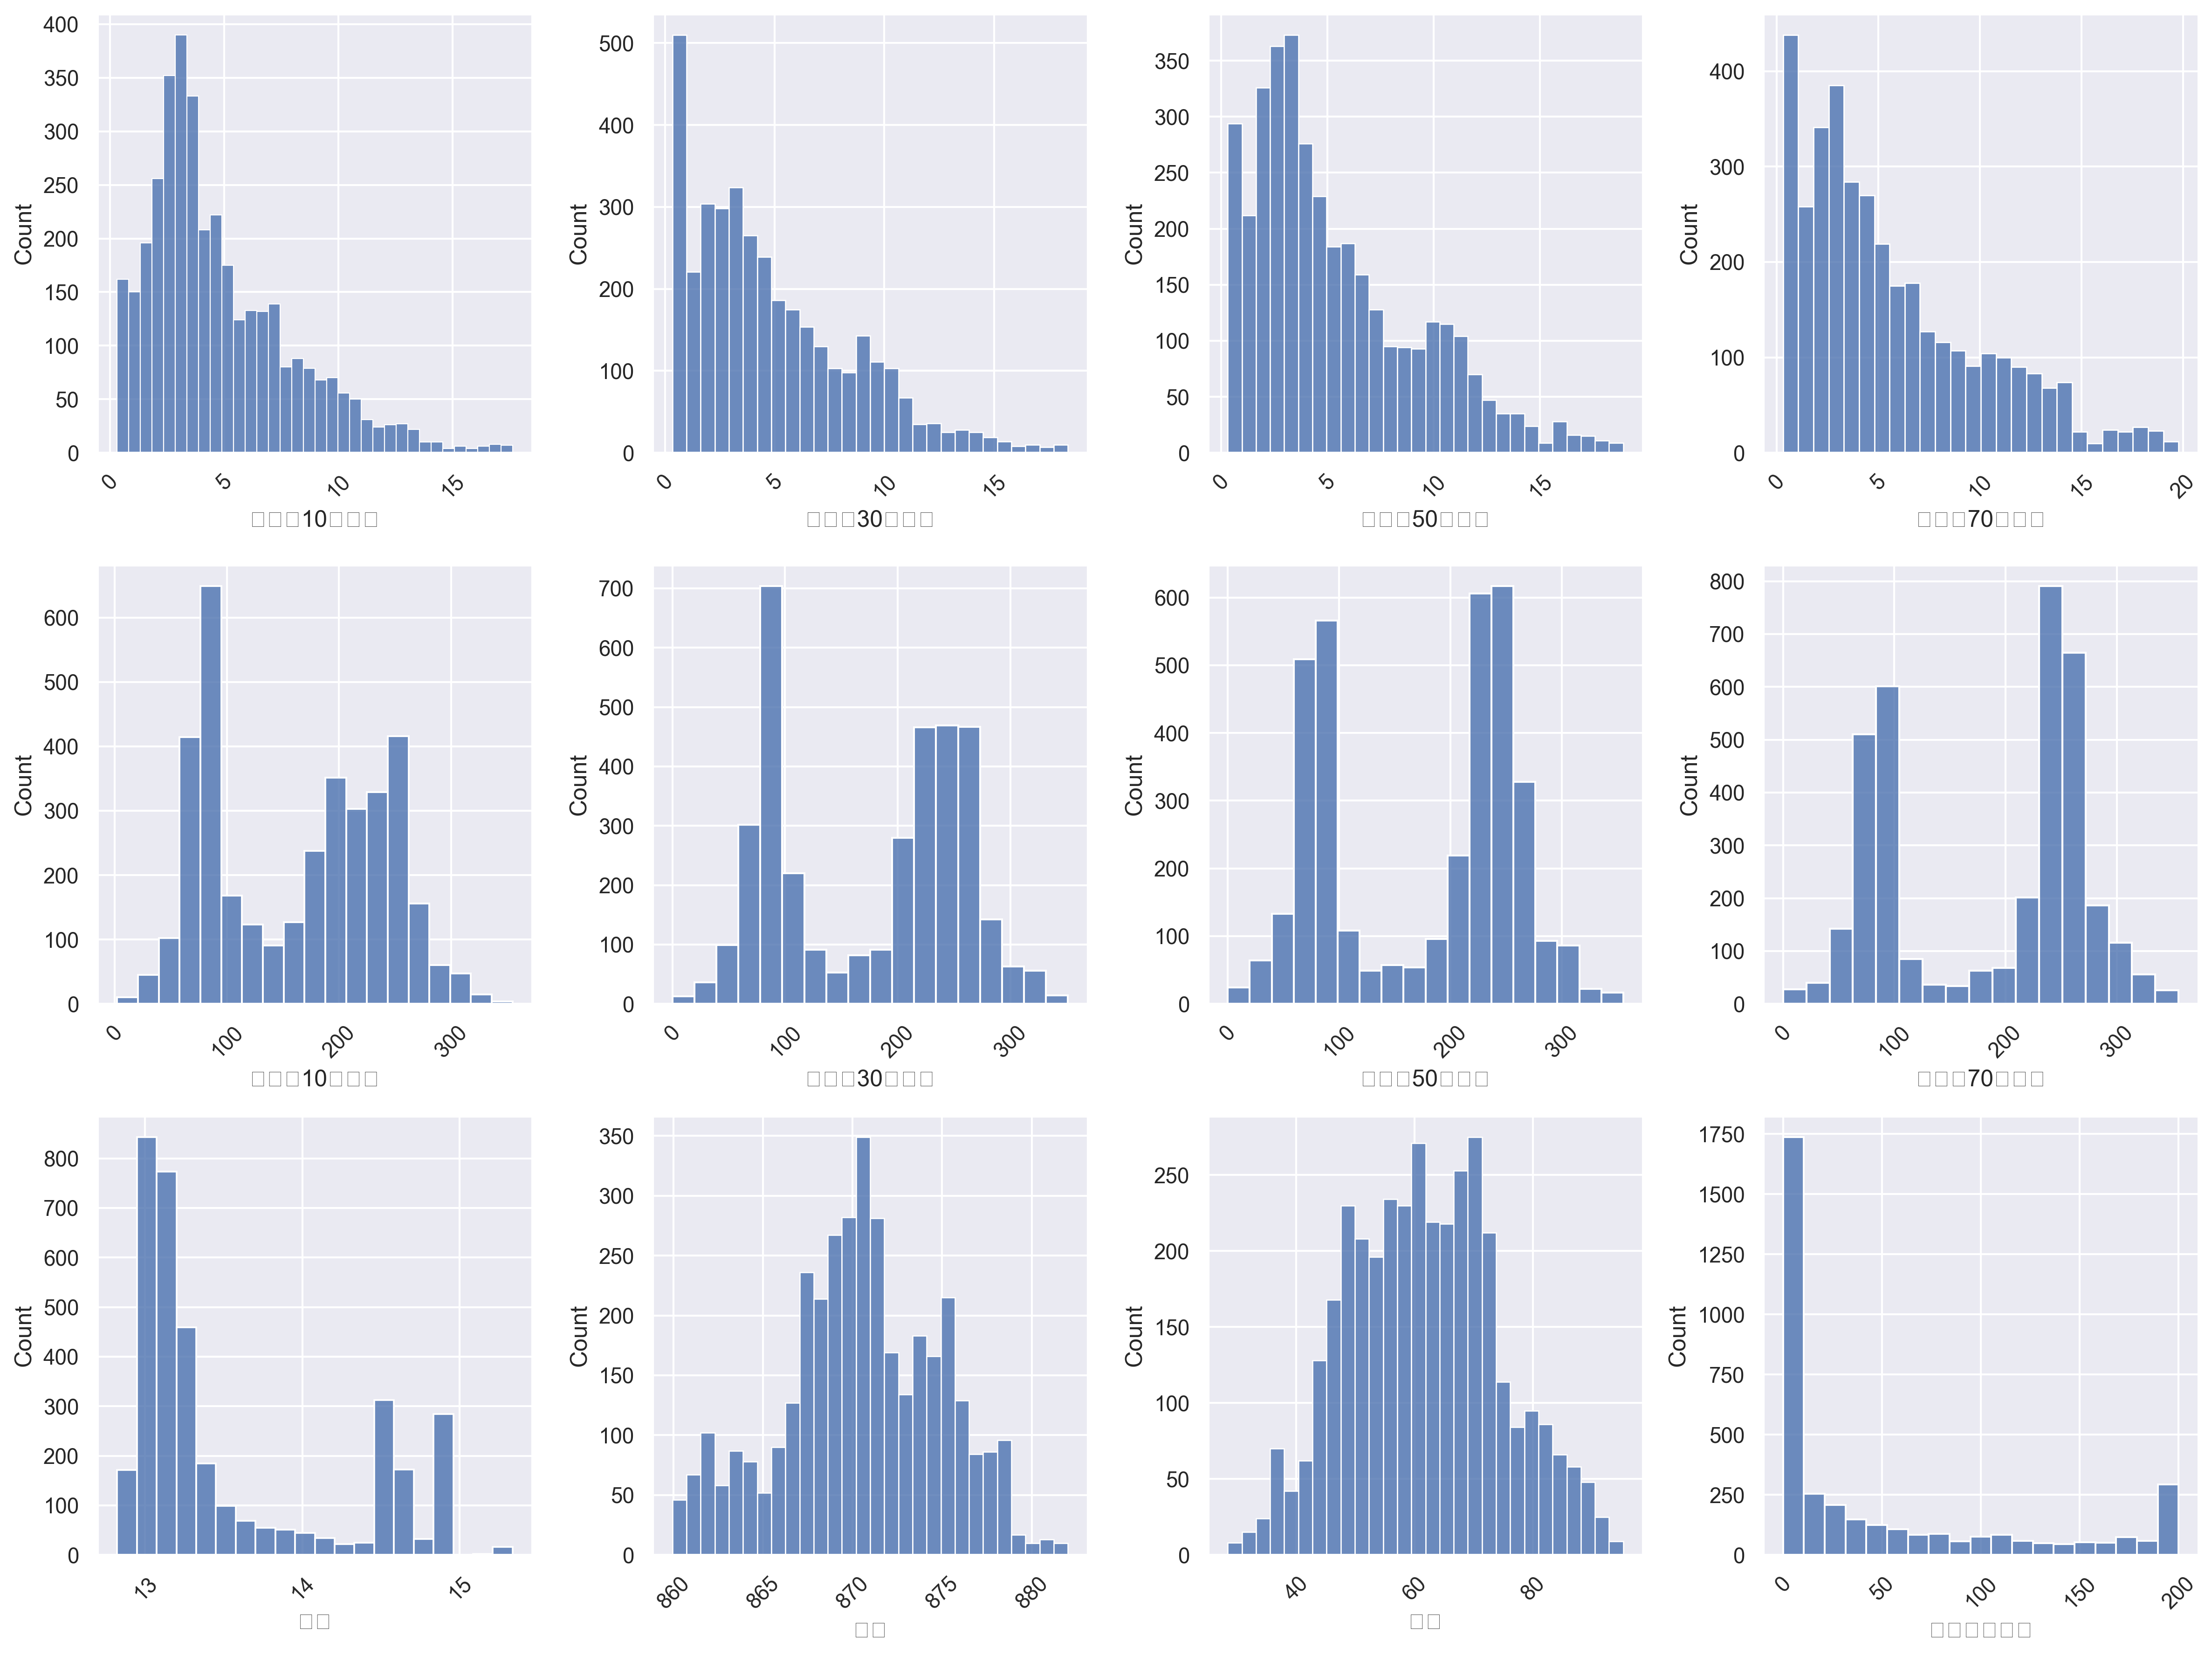

In [3]:
#--------------------------------2、数据探索--------------------------------#
import warnings
warnings.filterwarnings("ignore")

## 绘制全部指标的概览
sns.set_theme(font_scale=1)
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12), dpi = 300)
axes = axes.flatten()

# 循环绘制每个子图
for i, column in enumerate(data.columns):
    g = sns.histplot(data=data, x=column, color='b', alpha=0.8, ax=axes[i])

    locator = axes[i].get_xticks()
    axes[i].xaxis.set_major_locator(plt.FixedLocator(locator))
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.savefig(fname="数据概览.png")

## 三、数据预处理
### 3.1 异常值检测与处理
##### 箱线图

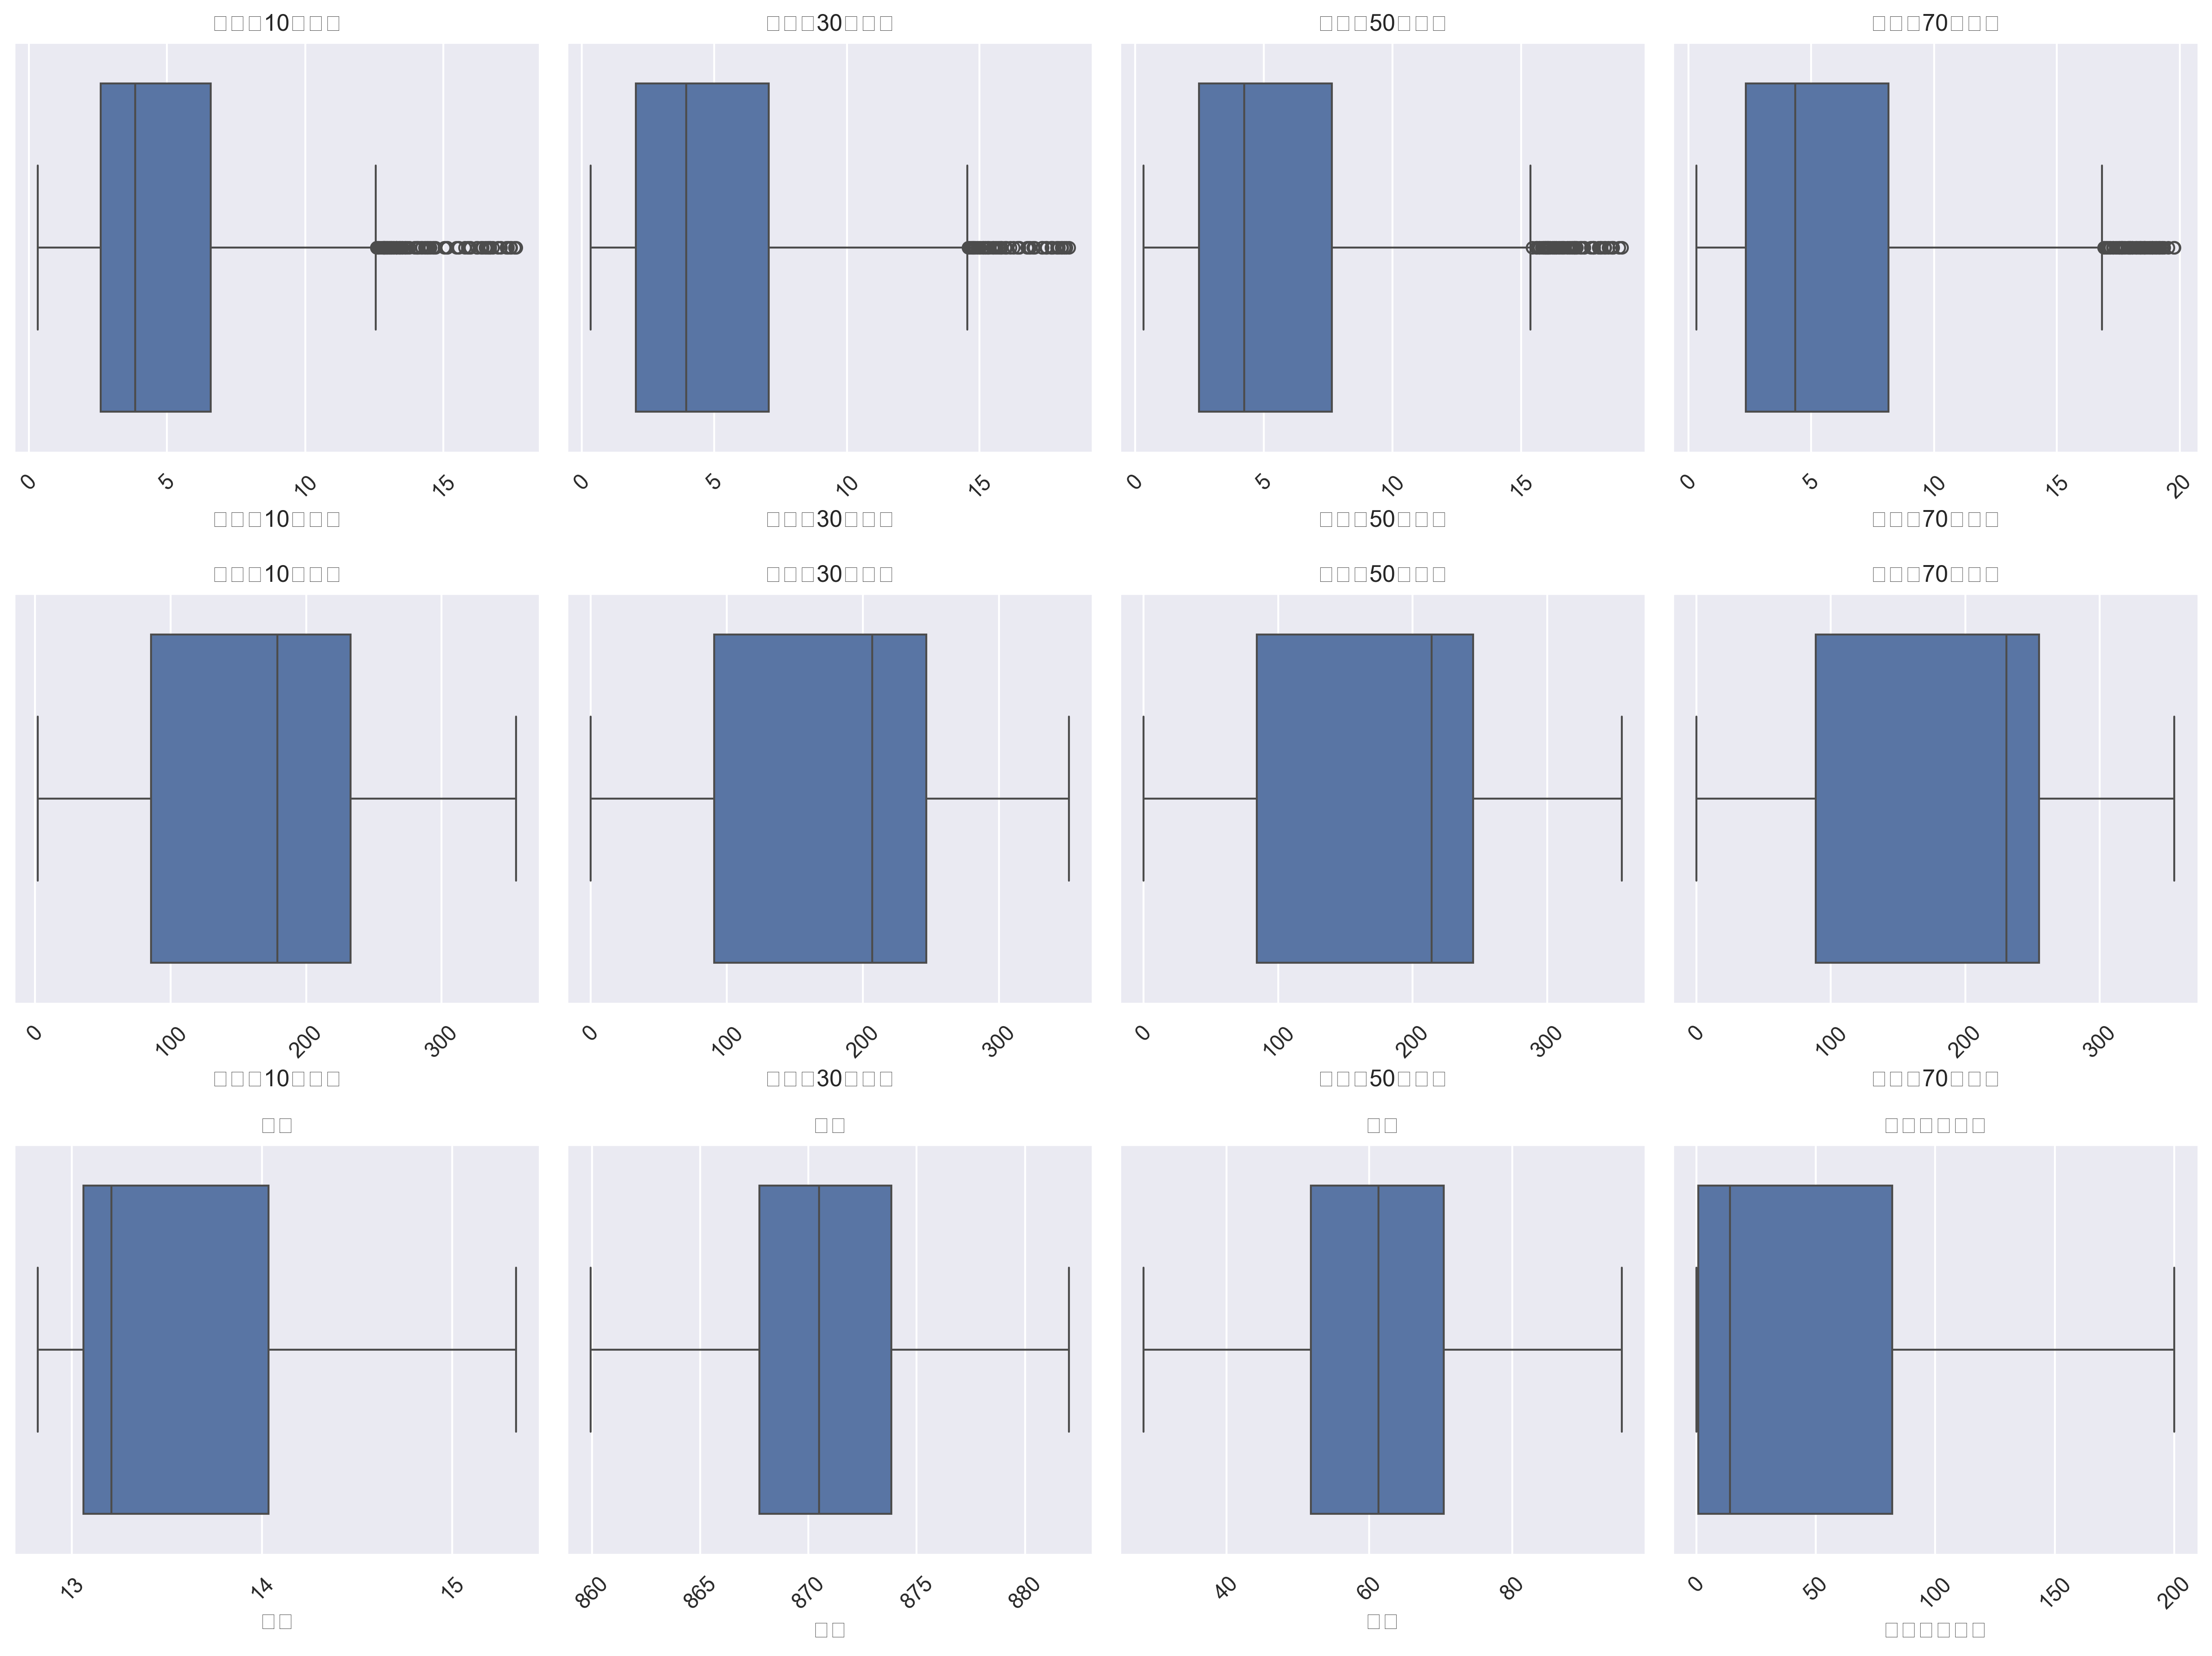

In [4]:
#--------------------------------3、数据预处理--------------------------------#

## 异常值检测与处理
# 箱线图
sns.set_theme(font_scale=1)
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12), dpi = 300)
axes = axes.flatten()

# 循环绘制每个子图
for i, column in enumerate(data.columns):
    g_previous_box = sns.boxplot(data=data, x=column, ax=axes[i])
    axes[i].set_title(column)

    locator = axes[i].get_xticks()
    axes[i].xaxis.set_major_locator(plt.FixedLocator(locator))
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.savefig(fname="箱线图.png")

##### 3$\sigma$法则

In [5]:
# 3sigma法则
for column in data.columns:
    mean_value = data[column].mean()
    std_value = data[column].std()
    lower_bound = mean_value - 3 * std_value
    upper_bound = mean_value + 3 * std_value
    outlier_count = data[(data[column] < lower_bound) | (data[column] > upper_bound)].shape[0]
    print(f"{column}列3sigma外离群值个数为: {outlier_count}")

测风塔10米风速列3sigma外离群值个数为: 40
测风塔30米风速列3sigma外离群值个数为: 31
测风塔50米风速列3sigma外离群值个数为: 27
测风塔70米风速列3sigma外离群值个数为: 20
测风塔10米风向列3sigma外离群值个数为: 0
测风塔30米风向列3sigma外离群值个数为: 0
测风塔50米风向列3sigma外离群值个数为: 0
测风塔70米风向列3sigma外离群值个数为: 0
温度列3sigma外离群值个数为: 0
气压列3sigma外离群值个数为: 0
湿度列3sigma外离群值个数为: 0
实际发电功率列3sigma外离群值个数为: 0


##### 异常值处理
替换为nan，空值

In [6]:
# 异常值处理
# 3sigma法则处理异常值，将3sigma外的数据替换为nan
for column in data.columns:
    mean_value = data[column].mean()
    std_value = data[column].std()
    lower_bound = mean_value - 3 * std_value
    upper_bound = mean_value + 3 * std_value

    # 将3sigma外的数据替换为nan
    data.loc[(data[column] < lower_bound) | (data[column] > upper_bound), column] = np.nan

    outlier_count = data[(data[column] < lower_bound) | (data[column] > upper_bound)].shape[0]
    print(f"{column}列3sigma外离群值个数为: {outlier_count}")

测风塔10米风速列3sigma外离群值个数为: 0
测风塔30米风速列3sigma外离群值个数为: 0
测风塔50米风速列3sigma外离群值个数为: 0
测风塔70米风速列3sigma外离群值个数为: 0
测风塔10米风向列3sigma外离群值个数为: 0
测风塔30米风向列3sigma外离群值个数为: 0
测风塔50米风向列3sigma外离群值个数为: 0
测风塔70米风向列3sigma外离群值个数为: 0
温度列3sigma外离群值个数为: 0
气压列3sigma外离群值个数为: 0
湿度列3sigma外离群值个数为: 0
实际发电功率列3sigma外离群值个数为: 0


### 3.2 缺失值检测与处理
##### 缺失情况

In [7]:
## 缺失值检测与处理
# 缺失比例
print('缺失值情况及比例：')
total_rows = data.shape[0]
missing_value_sums = data.isnull().sum()
missing_value_proportions = (missing_value_sums / total_rows) * 100

for column, missing_count in missing_value_sums.items():
    proportion = missing_value_proportions[column]
    print(f"{column}: 缺失值数量为 {missing_count}，缺失值比例为 {proportion:.2f}%")

缺失值情况及比例：
测风塔10米风速: 缺失值数量为 40，缺失值比例为 1.10%
测风塔30米风速: 缺失值数量为 31，缺失值比例为 0.85%
测风塔50米风速: 缺失值数量为 27，缺失值比例为 0.74%
测风塔70米风速: 缺失值数量为 20，缺失值比例为 0.55%
测风塔10米风向: 缺失值数量为 0，缺失值比例为 0.00%
测风塔30米风向: 缺失值数量为 0，缺失值比例为 0.00%
测风塔50米风向: 缺失值数量为 0，缺失值比例为 0.00%
测风塔70米风向: 缺失值数量为 0，缺失值比例为 0.00%
温度: 缺失值数量为 0，缺失值比例为 0.00%
气压: 缺失值数量为 0，缺失值比例为 0.00%
湿度: 缺失值数量为 0，缺失值比例为 0.00%
实际发电功率: 缺失值数量为 0，缺失值比例为 0.00%


##### 中位数插补

In [8]:
# 对于缺失比例小于5%，采用中位数直接插补
variables_to_impute = ['测风塔10米风速','测风塔30米风速', '测风塔50米风速','测风塔70米风速']

for variable in variables_to_impute:
    missing_proportion = missing_value_proportions[variable]
    if missing_proportion < 5:
        median_value = data[variable].median()
        data[variable].fillna(median_value, inplace=True)

##### 缺失情况

In [9]:
# 缺失比例
print('缺失值情况及比例：')
total_rows = data.shape[0]
missing_value_sums = data.isnull().sum()
missing_value_proportions = (missing_value_sums / total_rows) * 100

for column, missing_count in missing_value_sums.items():
    proportion = missing_value_proportions[column]
    print(f"{column}: 缺失值数量为 {missing_count}，缺失值比例为 {proportion:.2f}%")

缺失值情况及比例：
测风塔10米风速: 缺失值数量为 0，缺失值比例为 0.00%
测风塔30米风速: 缺失值数量为 0，缺失值比例为 0.00%
测风塔50米风速: 缺失值数量为 0，缺失值比例为 0.00%
测风塔70米风速: 缺失值数量为 0，缺失值比例为 0.00%
测风塔10米风向: 缺失值数量为 0，缺失值比例为 0.00%
测风塔30米风向: 缺失值数量为 0，缺失值比例为 0.00%
测风塔50米风向: 缺失值数量为 0，缺失值比例为 0.00%
测风塔70米风向: 缺失值数量为 0，缺失值比例为 0.00%
温度: 缺失值数量为 0，缺失值比例为 0.00%
气压: 缺失值数量为 0，缺失值比例为 0.00%
湿度: 缺失值数量为 0，缺失值比例为 0.00%
实际发电功率: 缺失值数量为 0，缺失值比例为 0.00%


__数据清洗完毕__
### 3.3 变量过滤
#### 3.3.1 低方差过滤

In [10]:
## 变量过滤
# 低方差过滤法
from sklearn.feature_selection import VarianceThreshold

threshold = 0.05 # 阈值

selector = VarianceThreshold(threshold=threshold)
selector.fit(data.drop('实际发电功率', axis=1))

selected_columns = data.drop('实际发电功率', axis=1).columns[selector.get_support()]

df_train_low_var = data[list(selected_columns) + ['实际发电功率']]

print("过滤前的数据形状：", data.shape)
print("经过低方差过滤后的数据形状：", df_train_low_var.shape)
print('所包含的变量', df_train_low_var.columns)

过滤前的数据形状： (3648, 12)
经过低方差过滤后的数据形状： (3648, 12)
所包含的变量 Index(['测风塔10米风速', '测风塔30米风速', '测风塔50米风速', '测风塔70米风速', '测风塔10米风向', '测风塔30米风向',
       '测风塔50米风向', '测风塔70米风向', '温度', '气压', '湿度', '实际发电功率'],
      dtype='object')


#### 3.3.2 高相关过滤

经过高相关过滤后的数据形状： (3648, 6)
所包含的变量 Index(['测风塔10米风速', '测风塔10米风向', '温度', '气压', '湿度', '实际发电功率'], dtype='object')


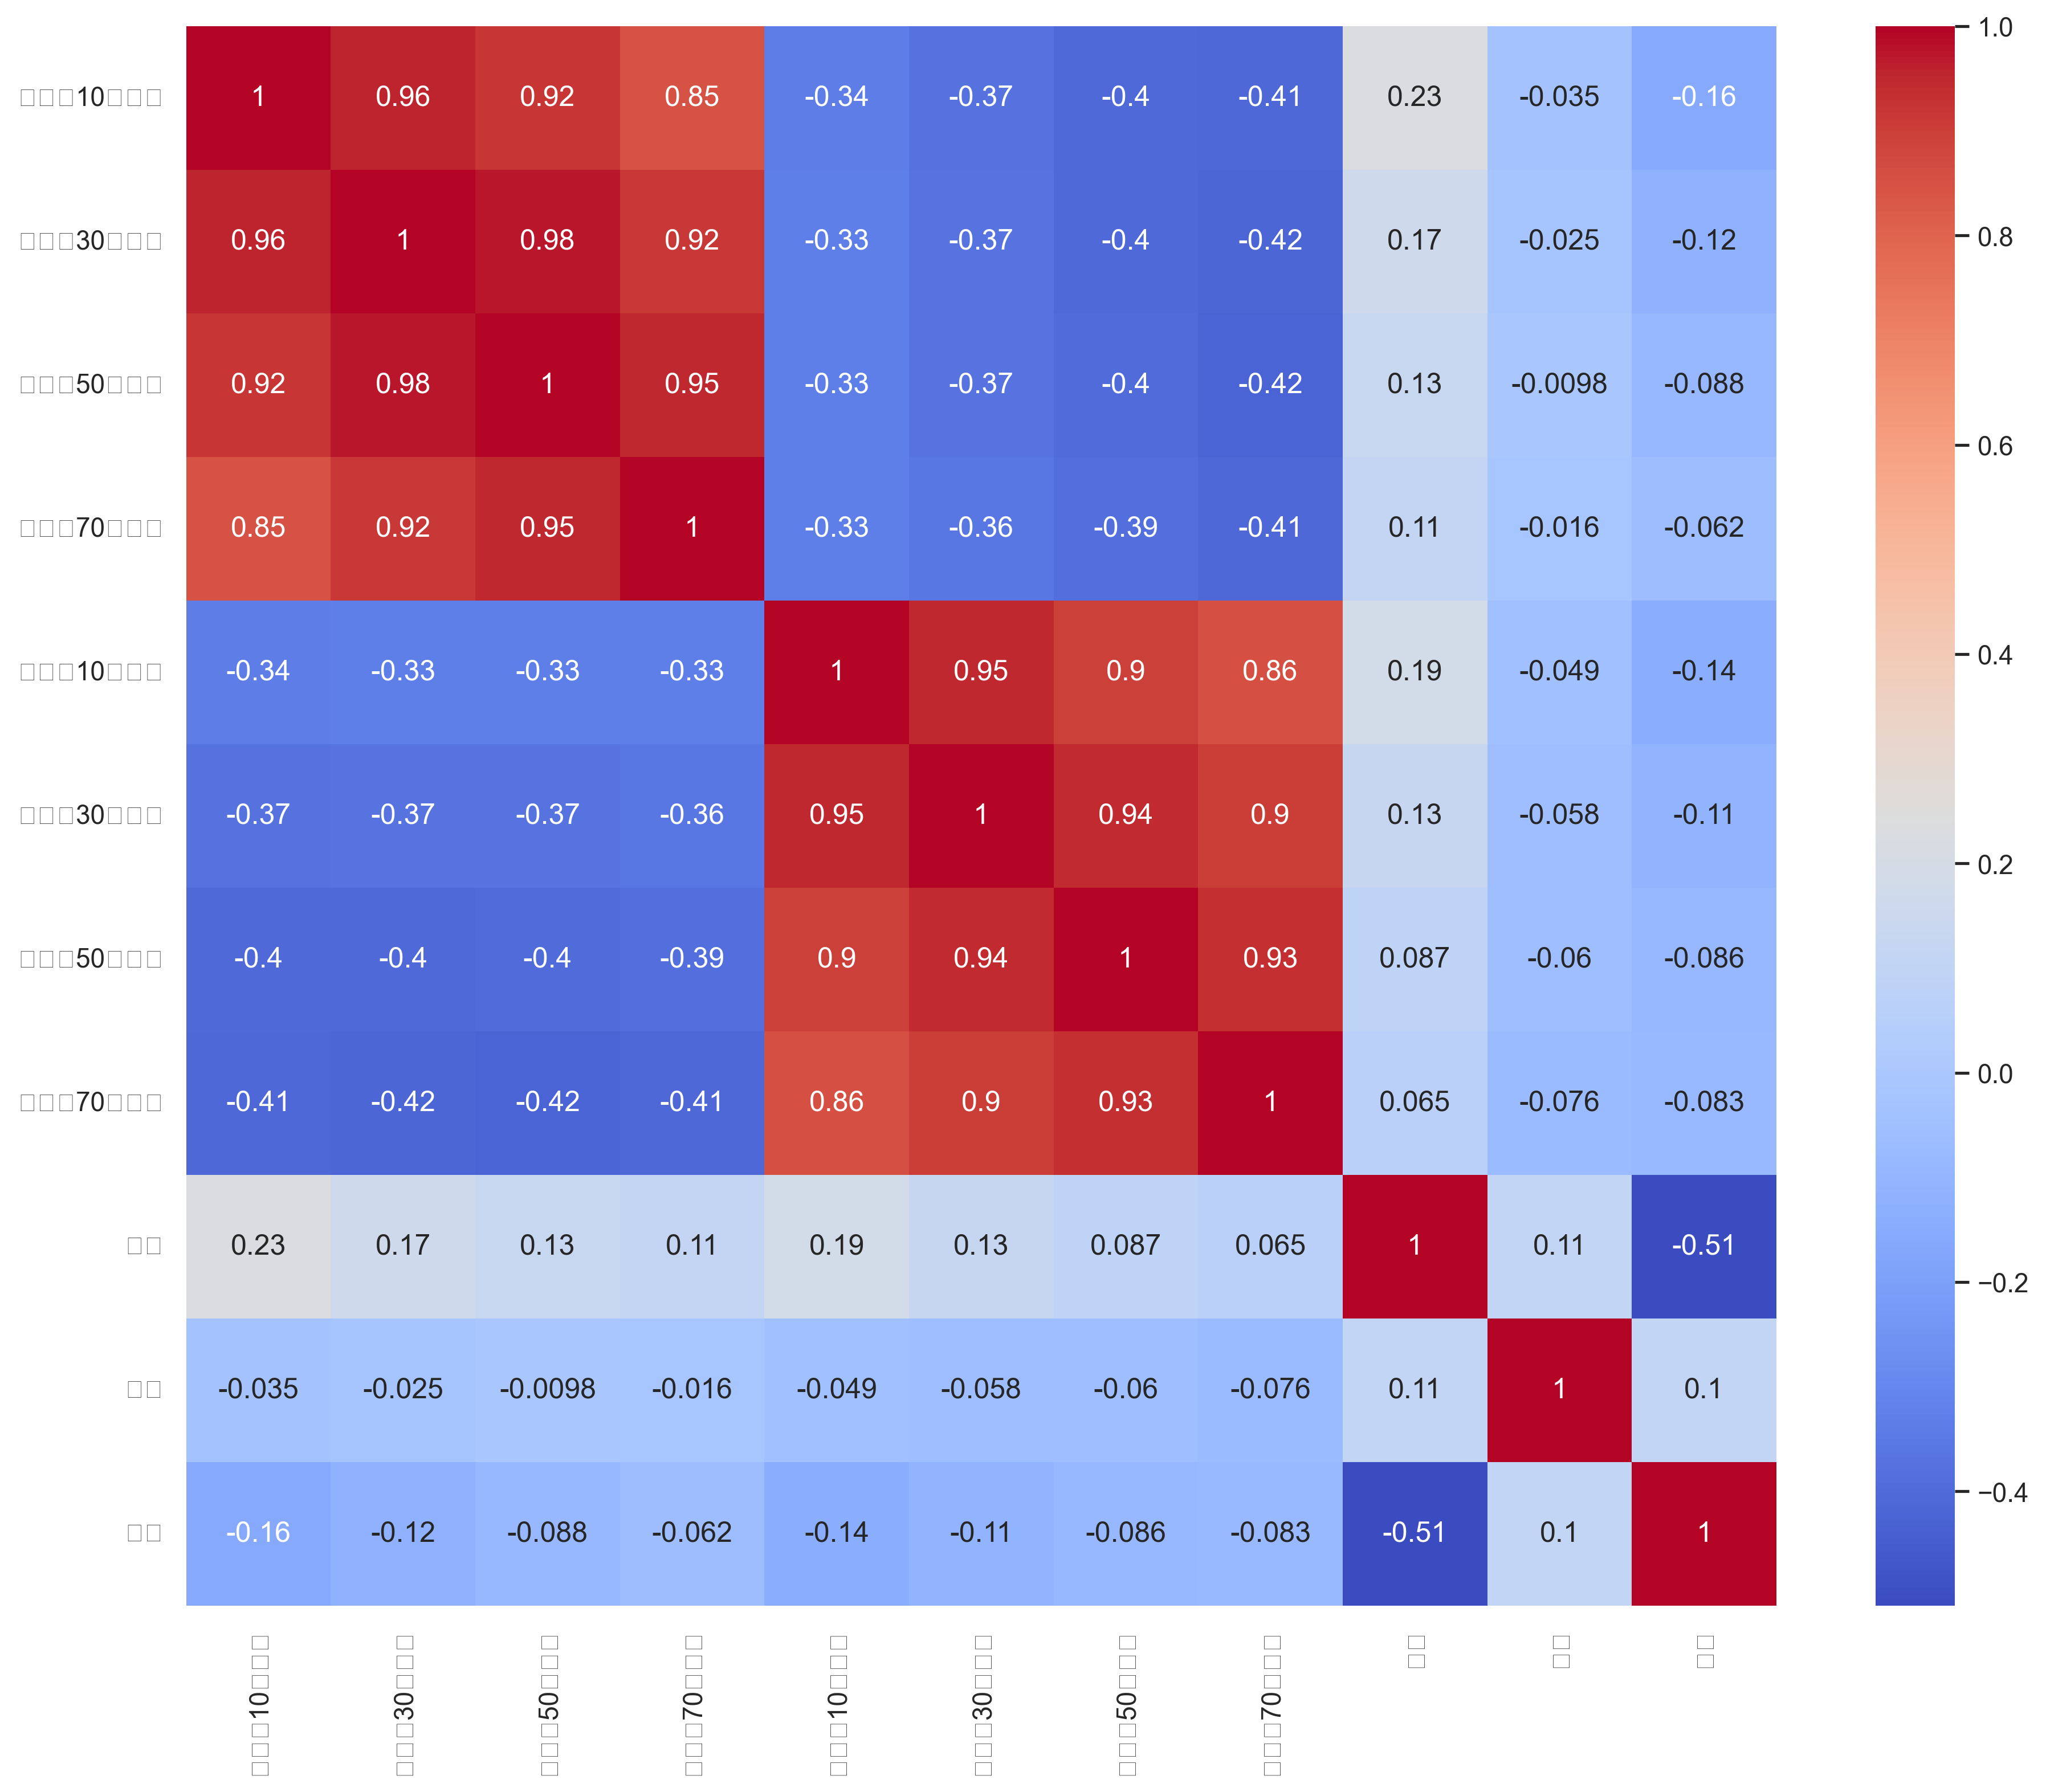

In [11]:
# 高相关过滤法
# 计算相关系数
input_vars = data.drop('实际发电功率', axis=1)
corr_matrix = input_vars.corr() # 皮尔森相关系数

# 绘制热图
plt.figure(figsize=(15, 12), dpi=300)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.savefig(fname="输入变量相关系数热图.png")

# 过滤
corr_matrix = df_train_low_var.drop('实际发电功率', axis=1).corr()
corr_threshold = 0.8 # 阈值

columns_to_drop = []

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > corr_threshold:
            columns_to_drop.append(corr_matrix.columns[j])

columns_to_drop = list(set(columns_to_drop))

data = df_train_low_var.drop(columns=columns_to_drop)

print("经过高相关过滤后的数据形状：", data.shape)
print('所包含的变量', data.columns)

__变量过滤完毕__
***
##### 划分输入输出

In [18]:
## 划分输入与输出
X_ = data.iloc[:, :-1].values
y_ = data.iloc[:, -1].values
y_ = y.reshape(-1, 1)

## 四、调参
### 4.1 归一化法
对比最大最小归一化和Z-sorce标准化
##### 最大最小归一化

In [17]:
# 归一化
# 最大最小归一化
minmax_scaler = MinMaxScaler()
X = minmax_scaler.fit_transform(X_)
y = minmax_scaler.fit_transform(y_)

# # zsocre标准化
# standard_scaler = StandardScaler()
# X = standard_scaler.fit_transform(X)
# y = standard_scaler.fit_transform(y)

## 划分训练集60%、测试集20%、测试集20%
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75)


#--------------------------------4、数据训练--------------------------------#

# 定义RBF层
class RBF_Layer(keras.layers.Layer):
    def __init__(self, n_centers, input_dim, **kwargs):
        super(RBF_Layer, self).__init__(**kwargs)
        self.centers = self.add_weight(
            shape=(n_centers, input_dim),
            initializer='random_normal',
            trainable=True
        )
        self.sigmas = self.add_weight(
            shape=(n_centers,),
            initializer='ones',
            trainable=True
        )

    def call(self, x):
        distances = tf.reduce_sum(tf.square(x[:, tf.newaxis, :] - self.centers[tf.newaxis, :, :]), axis=2)
        return tf.exp(-distances / (2 * tf.square(self.sigmas[tf.newaxis, :])))


# 定义神经网络
input_dim = X.shape[1]
def rbf_model():
    # 输入层
    inputs = Input(shape=(input_dim,))

    # 噪声层
    noise = GaussianNoise(0.1)(inputs)

    # RBF层
    rbf_out = RBF_Layer(n_centers=10, input_dim=input_dim)(noise)
    rbf_out = Flatten()(rbf_out)
    
    # 批量归一化层
    bn_out = BatchNormalization()(rbf_out)
    
    # Dropout层
    dropout = Dropout(0.2)(bn_out)

    # 输出层
    output = Dense(1, activation='softplus')(dropout)

    model = Model(inputs=[inputs], outputs=output)
    return model

# 创建RBF模型实例
rbf = rbf_model()

# 编译模型，选择合适的优化器、学习率和损失函数
learning_rate = 0.001
rbf.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate), loss='mse')

## 参数
early_stopping_patience = 3
epoch = 10
batch_size = 16

# 训练模型
# 早停法--验证集损失连续3个epoch没有改善就停止训练
early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
# 动态调整学习率--在训练过程中，当验证集的损失不再下降（达到平台期）时自动降低学习率
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
history = rbf.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

# 在测试集上评估模型
y_pred_test = rbf.predict(X_test)
mse_test_RBF = mean_squared_error(y_test, y_pred_test)
print('测试集MSE:', mse_test_RBF)
rmse_test_RBF = np.sqrt(mse_test_RBF)
print('测试集RMSE:', rmse_test_RBF)
mae_test_RBF = mean_absolute_error(y_test, y_pred_test)
print('测试集MAE:', mae_test_RBF)
mape_test_RBF = mean_absolute_percentage_error(y_test, y_pred_test)
print('测试集MAPE:', mape_test_RBF)
r2_test_RBF = r2_score(y_test, y_pred_test)
print('测试集R2:', r2_test_RBF)

Epoch 1/10
137/137 [==============================] - 0s 741us/step - loss: 0.3471 - val_loss: 0.1472 - lr: 0.0010
Epoch 2/10
137/137 [==============================] - 0s 410us/step - loss: 0.1678 - val_loss: 0.0921 - lr: 0.0010
Epoch 3/10
137/137 [==============================] - 0s 422us/step - loss: 0.1066 - val_loss: 0.0557 - lr: 0.0010
Epoch 4/10
137/137 [==============================] - 0s 425us/step - loss: 0.0898 - val_loss: 0.0358 - lr: 0.0010
Epoch 5/10
137/137 [==============================] - 0s 412us/step - loss: 0.0733 - val_loss: 0.0280 - lr: 0.0010
Epoch 6/10
137/137 [==============================] - 0s 416us/step - loss: 0.0700 - val_loss: 0.0272 - lr: 0.0010
Epoch 7/10
137/137 [==============================] - 0s 412us/step - loss: 0.0622 - val_loss: 0.0256 - lr: 0.0010
Epoch 8/10
137/137 [==============================] - 0s 416us/step - loss: 0.0627 - val_loss: 0.0250 - lr: 0.0010
Epoch 9/10
137/137 [==============================] - 0s 418us/step - loss: 0.06

##### Z-score标准化

In [19]:
# 归一化
# # 最大最小归一化
# minmax_scaler = MinMaxScaler()
# X = minmax_scaler.fit_transform(X_)
# y = minmax_scaler.fit_transform(y_)

# zsocre标准化
standard_scaler = StandardScaler()
X = standard_scaler.fit_transform(X_)
y = standard_scaler.fit_transform(y_)

## 划分训练集60%、测试集20%、测试集20%
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75)


#--------------------------------4、数据训练--------------------------------#

# 定义RBF层
class RBF_Layer(keras.layers.Layer):
    def __init__(self, n_centers, input_dim, **kwargs):
        super(RBF_Layer, self).__init__(**kwargs)
        self.centers = self.add_weight(
            shape=(n_centers, input_dim),
            initializer='random_normal',
            trainable=True
        )
        self.sigmas = self.add_weight(
            shape=(n_centers,),
            initializer='ones',
            trainable=True
        )

    def call(self, x):
        distances = tf.reduce_sum(tf.square(x[:, tf.newaxis, :] - self.centers[tf.newaxis, :, :]), axis=2)
        return tf.exp(-distances / (2 * tf.square(self.sigmas[tf.newaxis, :])))


# 定义神经网络
input_dim = X.shape[1]
def rbf_model():
    # 输入层
    inputs = Input(shape=(input_dim,))

    # 噪声层
    noise = GaussianNoise(0.1)(inputs)

    # RBF层
    rbf_out = RBF_Layer(n_centers=10, input_dim=input_dim)(noise)
    rbf_out = Flatten()(rbf_out)
    
    # 批量归一化层
    bn_out = BatchNormalization()(rbf_out)
    
    # Dropout层
    dropout = Dropout(0.2)(bn_out)

    # 输出层
    output = Dense(1, activation='softplus')(dropout)

    model = Model(inputs=[inputs], outputs=output)
    return model

# 创建RBF模型实例
rbf = rbf_model()

# 编译模型，选择合适的优化器、学习率和损失函数
learning_rate = 0.001
rbf.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate), loss='mse')

## 参数
early_stopping_patience = 3
epoch = 10
batch_size = 16

# 训练模型
# 早停法--验证集损失连续3个epoch没有改善就停止训练
early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
# 动态调整学习率--在训练过程中，当验证集的损失不再下降（达到平台期）时自动降低学习率
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
history = rbf.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

# 在测试集上评估模型
y_pred_test = rbf.predict(X_test)
mse_test_RBF = mean_squared_error(y_test, y_pred_test)
print('测试集MSE:', mse_test_RBF)
rmse_test_RBF = np.sqrt(mse_test_RBF)
print('测试集RMSE:', rmse_test_RBF)
mae_test_RBF = mean_absolute_error(y_test, y_pred_test)
print('测试集MAE:', mae_test_RBF)
mape_test_RBF = mean_absolute_percentage_error(y_test, y_pred_test)
print('测试集MAPE:', mape_test_RBF)
r2_test_RBF = r2_score(y_test, y_pred_test)
print('测试集R2:', r2_test_RBF)

Epoch 1/10
137/137 [==============================] - 0s 911us/step - loss: 1.3868 - val_loss: 1.1867 - lr: 0.0010
Epoch 2/10
137/137 [==============================] - 0s 443us/step - loss: 1.1155 - val_loss: 1.0440 - lr: 0.0010
Epoch 3/10
137/137 [==============================] - 0s 451us/step - loss: 1.0119 - val_loss: 0.9401 - lr: 0.0010
Epoch 4/10
137/137 [==============================] - 0s 446us/step - loss: 0.9554 - val_loss: 0.8618 - lr: 0.0010
Epoch 5/10
137/137 [==============================] - 0s 438us/step - loss: 0.8868 - val_loss: 0.7954 - lr: 0.0010
Epoch 6/10
137/137 [==============================] - 0s 439us/step - loss: 0.8317 - val_loss: 0.7435 - lr: 0.0010
Epoch 7/10
137/137 [==============================] - 0s 435us/step - loss: 0.7982 - val_loss: 0.6831 - lr: 0.0010
Epoch 8/10
137/137 [==============================] - 0s 432us/step - loss: 0.7454 - val_loss: 0.6248 - lr: 0.0010
Epoch 9/10
137/137 [==============================] - 0s 451us/step - loss: 0.69

__选择最大最小归一化__

### 4.2 Batch size
网格搜索

In [23]:
## 划分输入与输出
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
y = y.reshape(-1, 1)

# 归一化
# 最大最小归一化
minmax_scaler = MinMaxScaler()
X = minmax_scaler.fit_transform(X)
y = minmax_scaler.fit_transform(y)

#--------------------------------4、数据训练--------------------------------#

# 定义RBF层
class RBF_Layer(keras.layers.Layer):
    def __init__(self, n_centers, input_dim, **kwargs):
        super(RBF_Layer, self).__init__(**kwargs)
        self.centers = self.add_weight(
            shape=(n_centers, input_dim),
            initializer='random_normal',
            trainable=True
        )
        self.sigmas = self.add_weight(
            shape=(n_centers,),
            initializer='ones',
            trainable=True
        )

    def call(self, x):
        distances = tf.reduce_sum(tf.square(x[:, tf.newaxis, :] - self.centers[tf.newaxis, :, :]), axis=2)
        return tf.exp(-distances / (2 * tf.square(self.sigmas[tf.newaxis, :])))


# 定义神经网络
input_dim = X.shape[1]
def rbf_model():
    # 输入层
    inputs = Input(shape=(input_dim,))

    # 噪声层
    noise = GaussianNoise(0.1)(inputs)

    # RBF层
    rbf_out = RBF_Layer(n_centers=10, input_dim=input_dim)(noise)
    rbf_out = Flatten()(rbf_out)
    
    # 批量归一化层
    bn_out = BatchNormalization()(rbf_out)
    
    # Dropout层
    dropout = Dropout(0.2)(bn_out)

    # 输出层
    output = Dense(1, activation='softplus')(dropout)

    model = Model(inputs=[inputs], outputs=output)
    return model

batch_sizes = [16, 32, 64]  # 定义要尝试的不同batch_size值
best_batch_size = None
best_mse = float('inf')

for batch_size in batch_sizes:
    # 创建RBF模型实例
    rbf = rbf_model()
    # 编译模型，选择合适的优化器、学习率和损失函数
    learning_rate = 0.001
    rbf.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate), loss='mse')
    
    ## 参数
    early_stopping_patience = 3
    epoch = 10
    
    # 训练模型
    # 早停法--验证集损失连续3个epoch没有改善就停止训练
    early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
    # 动态调整学习率--在训练过程中，当验证集的损失不再下降（达到平台期）时自动降低学习率
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
    history = rbf.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])
    
    # 在测试集上评估模型
    y_pred_test = rbf.predict(X_test)
    mse_test_RBF = mean_squared_error(y_test, y_pred_test)
    print(f'当前batch_size {batch_size} 对应的测试集MSE: {mse_test_RBF}')
    if mse_test_RBF < best_mse:
        best_mse = mse_test_RBF
        best_batch_size = batch_size

print(f'最佳batch_size为: {best_batch_size}，对应的最小测试集MSE为: {best_mse}')

Epoch 1/10
137/137 [==============================] - 0s 1ms/step - loss: 1.3566 - val_loss: 1.1499 - lr: 0.0010
Epoch 2/10
137/137 [==============================] - 0s 461us/step - loss: 1.0965 - val_loss: 1.0108 - lr: 0.0010
Epoch 3/10
137/137 [==============================] - 0s 439us/step - loss: 1.0065 - val_loss: 0.9237 - lr: 0.0010
Epoch 4/10
137/137 [==============================] - 0s 428us/step - loss: 0.9463 - val_loss: 0.8552 - lr: 0.0010
Epoch 5/10
137/137 [==============================] - 0s 407us/step - loss: 0.8915 - val_loss: 0.7963 - lr: 0.0010
Epoch 6/10
137/137 [==============================] - 0s 441us/step - loss: 0.8355 - val_loss: 0.7435 - lr: 0.0010
Epoch 7/10
137/137 [==============================] - 0s 439us/step - loss: 0.8314 - val_loss: 0.7145 - lr: 0.0010
Epoch 8/10
137/137 [==============================] - 0s 441us/step - loss: 0.7878 - val_loss: 0.6610 - lr: 0.0010
Epoch 9/10
137/137 [==============================] - 0s 428us/step - loss: 0.7490

### 4.3 学习率
网格搜索

In [25]:
## 划分输入与输出
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
y = y.reshape(-1, 1)

# 归一化
# 最大最小归一化
minmax_scaler = MinMaxScaler()
X = minmax_scaler.fit_transform(X)
y = minmax_scaler.fit_transform(y)

#--------------------------------4、数据训练--------------------------------#

# 定义RBF层
class RBF_Layer(keras.layers.Layer):
    def __init__(self, n_centers, input_dim, **kwargs):
        super(RBF_Layer, self).__init__(**kwargs)
        self.centers = self.add_weight(
            shape=(n_centers, input_dim),
            initializer='random_normal',
            trainable=True
        )
        self.sigmas = self.add_weight(
            shape=(n_centers,),
            initializer='ones',
            trainable=True
        )

    def call(self, x):
        distances = tf.reduce_sum(tf.square(x[:, tf.newaxis, :] - self.centers[tf.newaxis, :, :]), axis=2)
        return tf.exp(-distances / (2 * tf.square(self.sigmas[tf.newaxis, :])))


# 定义神经网络
input_dim = X.shape[1]
def rbf_model():
    # 输入层
    inputs = Input(shape=(input_dim,))

    # 噪声层
    noise = GaussianNoise(0.1)(inputs)

    # RBF层
    rbf_out = RBF_Layer(n_centers=10, input_dim=input_dim)(noise)
    rbf_out = Flatten()(rbf_out)
    
    # 批量归一化层
    bn_out = BatchNormalization()(rbf_out)
    
    # Dropout层
    dropout = Dropout(0.2)(bn_out)

    # 输出层
    output = Dense(1, activation='softplus')(dropout)

    model = Model(inputs=[inputs], outputs=output)
    return model

learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001] 
best_learning_rate = None
best_mse = float('inf')

for learning_rate in learning_rates:
    # 创建RBF模型实例
    rbf = rbf_model()
    # 编译模型，选择合适的优化器、学习率和损失函数
    learning_rate = learning_rate
    rbf.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate), loss='mse')
    
    ## 参数
    early_stopping_patience = 3
    epoch = 10
    batch_size = 16
    
    # 训练模型
    # 早停法--验证集损失连续3个epoch没有改善就停止训练
    early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
    # 动态调整学习率--在训练过程中，当验证集的损失不再下降（达到平台期）时自动降低学习率
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
    history = rbf.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])
    
    # 在测试集上评估模型
    y_pred_test = rbf.predict(X_test)
    mse_test_RBF = mean_squared_error(y_test, y_pred_test)
    print(f'当前learning_rate {learning_rate} 对应的测试集MSE: {mse_test_RBF}')
    if mse_test_RBF < best_mse:
        best_mse = mse_test_RBF
        best_learning_rate = learning_rate

print(f'最佳batch_size为: {best_learning_rate}，对应的最小测试集MSE为: {best_mse}')

Epoch 1/10
137/137 [==============================] - 0s 853us/step - loss: 0.7751 - val_loss: 0.9299 - lr: 0.1000
Epoch 2/10
137/137 [==============================] - 0s 475us/step - loss: 0.6092 - val_loss: 0.7626 - lr: 0.1000
Epoch 3/10
137/137 [==============================] - 0s 424us/step - loss: 0.5772 - val_loss: 0.5445 - lr: 0.1000
Epoch 4/10
137/137 [==============================] - 0s 420us/step - loss: 0.6013 - val_loss: 0.5860 - lr: 0.1000
Epoch 5/10
137/137 [==============================] - 0s 425us/step - loss: 0.5760 - val_loss: 0.4639 - lr: 0.1000
Epoch 6/10
137/137 [==============================] - 0s 419us/step - loss: 0.6082 - val_loss: 0.6660 - lr: 0.1000
Epoch 7/10
137/137 [==============================] - 0s 434us/step - loss: 0.5847 - val_loss: 0.4671 - lr: 0.1000
Epoch 8/10
137/137 [==============================] - 0s 436us/step - loss: 0.5566 - val_loss: 0.4233 - lr: 0.0100
Epoch 9/10
137/137 [==============================] - 0s 409us/step - loss: 0.54

### 4.4 Dropout率
网格搜索

In [28]:
## 划分输入与输出
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
y = y.reshape(-1, 1)

# 归一化
# 最大最小归一化
minmax_scaler = MinMaxScaler()
X = minmax_scaler.fit_transform(X)
y = minmax_scaler.fit_transform(y)

# # zsocre标准化
# standard_scaler = StandardScaler()
# X = standard_scaler.fit_transform(X)
# y = standard_scaler.fit_transform(y)

## 划分训练集60%、测试集20%、测试集20%
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75)


#--------------------------------4、数据训练--------------------------------#

# 定义RBF层
class RBF_Layer(keras.layers.Layer):
    def __init__(self, n_centers, input_dim, **kwargs):
        super(RBF_Layer, self).__init__(**kwargs)
        self.centers = self.add_weight(
            shape=(n_centers, input_dim),
            initializer='random_normal',
            trainable=True
        )
        self.sigmas = self.add_weight(
            shape=(n_centers,),
            initializer='ones',
            trainable=True
        )

    def call(self, x):
        distances = tf.reduce_sum(tf.square(x[:, tf.newaxis, :] - self.centers[tf.newaxis, :, :]), axis=2)
        return tf.exp(-distances / (2 * tf.square(self.sigmas[tf.newaxis, :])))


# 定义神经网络
input_dim = X.shape[1]
def rbf_model():
    # 输入层
    inputs = Input(shape=(input_dim,))

    # 噪声层
    noise = GaussianNoise(0.1)(inputs)

    # RBF层
    rbf_out = RBF_Layer(n_centers=10, input_dim=input_dim)(noise)
    rbf_out = Flatten()(rbf_out)
    
    # 批量归一化层
    bn_out = BatchNormalization()(rbf_out)
    
    # Dropout层
    dropout = Dropout(0.1)(bn_out)

    # 输出层
    output = Dense(1, activation='softplus')(dropout)

    model = Model(inputs=[inputs], outputs=output)
    return model

# 创建RBF模型实例
rbf = rbf_model()

# 编译模型，选择合适的优化器、学习率和损失函数
learning_rate = 0.005
rbf.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate), loss='mse')

## 参数
early_stopping_patience = 3
epoch = 10
batch_size = 16

# 训练模型
# 早停法--验证集损失连续3个epoch没有改善就停止训练
early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
# 动态调整学习率--在训练过程中，当验证集的损失不再下降（达到平台期）时自动降低学习率
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
history = rbf.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

# 在测试集上评估模型
y_pred_test = rbf.predict(X_test)
mse_test_RBF = mean_squared_error(y_test, y_pred_test)
print('测试集MSE:', mse_test_RBF)
rmse_test_RBF = np.sqrt(mse_test_RBF)
print('测试集RMSE:', rmse_test_RBF)
mae_test_RBF = mean_absolute_error(y_test, y_pred_test)
print('测试集MAE:', mae_test_RBF)
mape_test_RBF = mean_absolute_percentage_error(y_test, y_pred_test)
print('测试集MAPE:', mape_test_RBF)
r2_test_RBF = r2_score(y_test, y_pred_test)
print('测试集R2:', r2_test_RBF)

## 划分输入与输出
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
y = y.reshape(-1, 1)

# 归一化
# 最大最小归一化
minmax_scaler = MinMaxScaler()
X = minmax_scaler.fit_transform(X)
y = minmax_scaler.fit_transform(y)

# # zsocre标准化
# standard_scaler = StandardScaler()
# X = standard_scaler.fit_transform(X)
# y = standard_scaler.fit_transform(y)

## 划分训练集60%、测试集20%、测试集20%
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75)


#--------------------------------4、数据训练--------------------------------#

# 定义RBF层
class RBF_Layer(keras.layers.Layer):
    def __init__(self, n_centers, input_dim, **kwargs):
        super(RBF_Layer, self).__init__(**kwargs)
        self.centers = self.add_weight(
            shape=(n_centers, input_dim),
            initializer='random_normal',
            trainable=True
        )
        self.sigmas = self.add_weight(
            shape=(n_centers,),
            initializer='ones',
            trainable=True
        )

    def call(self, x):
        distances = tf.reduce_sum(tf.square(x[:, tf.newaxis, :] - self.centers[tf.newaxis, :, :]), axis=2)
        return tf.exp(-distances / (2 * tf.square(self.sigmas[tf.newaxis, :])))


# 定义神经网络
input_dim = X.shape[1]
def rbf_model():
    # 输入层
    inputs = Input(shape=(input_dim,))

    # 噪声层
    noise = GaussianNoise(0.1)(inputs)

    # RBF层
    rbf_out = RBF_Layer(n_centers=10, input_dim=input_dim)(noise)
    rbf_out = Flatten()(rbf_out)
    
    # 批量归一化层
    bn_out = BatchNormalization()(rbf_out)
    
    # Dropout层
    dropout = Dropout(0.2)(bn_out)

    # 输出层
    output = Dense(1, activation='softplus')(dropout)

    model = Model(inputs=[inputs], outputs=output)
    return model

# 创建RBF模型实例
rbf = rbf_model()

# 编译模型，选择合适的优化器、学习率和损失函数
learning_rate = 0.005
rbf.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate), loss='mse')

## 参数
early_stopping_patience = 3
epoch = 10
batch_size = 16

# 训练模型
# 早停法--验证集损失连续3个epoch没有改善就停止训练
early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
# 动态调整学习率--在训练过程中，当验证集的损失不再下降（达到平台期）时自动降低学习率
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
history = rbf.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

# 在测试集上评估模型
y_pred_test = rbf.predict(X_test)
mse_test_RBF = mean_squared_error(y_test, y_pred_test)
print('测试集MSE:', mse_test_RBF)
rmse_test_RBF = np.sqrt(mse_test_RBF)
print('测试集RMSE:', rmse_test_RBF)
mae_test_RBF = mean_absolute_error(y_test, y_pred_test)
print('测试集MAE:', mae_test_RBF)
mape_test_RBF = mean_absolute_percentage_error(y_test, y_pred_test)
print('测试集MAPE:', mape_test_RBF)
r2_test_RBF = r2_score(y_test, y_pred_test)
print('测试集R2:', r2_test_RBF)

## 划分输入与输出
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
y = y.reshape(-1, 1)

# 归一化
# 最大最小归一化
minmax_scaler = MinMaxScaler()
X = minmax_scaler.fit_transform(X)
y = minmax_scaler.fit_transform(y)

# # zsocre标准化
# standard_scaler = StandardScaler()
# X = standard_scaler.fit_transform(X)
# y = standard_scaler.fit_transform(y)

## 划分训练集60%、测试集20%、测试集20%
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75)


#--------------------------------4、数据训练--------------------------------#

# 定义RBF层
class RBF_Layer(keras.layers.Layer):
    def __init__(self, n_centers, input_dim, **kwargs):
        super(RBF_Layer, self).__init__(**kwargs)
        self.centers = self.add_weight(
            shape=(n_centers, input_dim),
            initializer='random_normal',
            trainable=True
        )
        self.sigmas = self.add_weight(
            shape=(n_centers,),
            initializer='ones',
            trainable=True
        )

    def call(self, x):
        distances = tf.reduce_sum(tf.square(x[:, tf.newaxis, :] - self.centers[tf.newaxis, :, :]), axis=2)
        return tf.exp(-distances / (2 * tf.square(self.sigmas[tf.newaxis, :])))


# 定义神经网络
input_dim = X.shape[1]
def rbf_model():
    # 输入层
    inputs = Input(shape=(input_dim,))

    # 噪声层
    noise = GaussianNoise(0.1)(inputs)

    # RBF层
    rbf_out = RBF_Layer(n_centers=10, input_dim=input_dim)(noise)
    rbf_out = Flatten()(rbf_out)
    
    # 批量归一化层
    bn_out = BatchNormalization()(rbf_out)
    
    # Dropout层
    dropout = Dropout(0.3)(bn_out)

    # 输出层
    output = Dense(1, activation='softplus')(dropout)

    model = Model(inputs=[inputs], outputs=output)
    return model

# 创建RBF模型实例
rbf = rbf_model()

# 编译模型，选择合适的优化器、学习率和损失函数
learning_rate = 0.005
rbf.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate), loss='mse')

## 参数
early_stopping_patience = 3
epoch = 10
batch_size = 16

# 训练模型
# 早停法--验证集损失连续3个epoch没有改善就停止训练
early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
# 动态调整学习率--在训练过程中，当验证集的损失不再下降（达到平台期）时自动降低学习率
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
history = rbf.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

# 在测试集上评估模型
y_pred_test = rbf.predict(X_test)
mse_test_RBF = mean_squared_error(y_test, y_pred_test)
print('测试集MSE:', mse_test_RBF)
rmse_test_RBF = np.sqrt(mse_test_RBF)
print('测试集RMSE:', rmse_test_RBF)
mae_test_RBF = mean_absolute_error(y_test, y_pred_test)
print('测试集MAE:', mae_test_RBF)
mape_test_RBF = mean_absolute_percentage_error(y_test, y_pred_test)
print('测试集MAPE:', mape_test_RBF)
r2_test_RBF = r2_score(y_test, y_pred_test)
print('测试集R2:', r2_test_RBF)

## 划分输入与输出
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
y = y.reshape(-1, 1)

# 归一化
# 最大最小归一化
minmax_scaler = MinMaxScaler()
X = minmax_scaler.fit_transform(X)
y = minmax_scaler.fit_transform(y)

# # zsocre标准化
# standard_scaler = StandardScaler()
# X = standard_scaler.fit_transform(X)
# y = standard_scaler.fit_transform(y)

## 划分训练集60%、测试集20%、测试集20%
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75)


#--------------------------------4、数据训练--------------------------------#

# 定义RBF层
class RBF_Layer(keras.layers.Layer):
    def __init__(self, n_centers, input_dim, **kwargs):
        super(RBF_Layer, self).__init__(**kwargs)
        self.centers = self.add_weight(
            shape=(n_centers, input_dim),
            initializer='random_normal',
            trainable=True
        )
        self.sigmas = self.add_weight(
            shape=(n_centers,),
            initializer='ones',
            trainable=True
        )

    def call(self, x):
        distances = tf.reduce_sum(tf.square(x[:, tf.newaxis, :] - self.centers[tf.newaxis, :, :]), axis=2)
        return tf.exp(-distances / (2 * tf.square(self.sigmas[tf.newaxis, :])))


# 定义神经网络
input_dim = X.shape[1]
def rbf_model():
    # 输入层
    inputs = Input(shape=(input_dim,))

    # 噪声层
    noise = GaussianNoise(0.1)(inputs)

    # RBF层
    rbf_out = RBF_Layer(n_centers=10, input_dim=input_dim)(noise)
    rbf_out = Flatten()(rbf_out)
    
    # 批量归一化层
    bn_out = BatchNormalization()(rbf_out)
    
    # Dropout层
    dropout = Dropout(0.4)(bn_out)

    # 输出层
    output = Dense(1, activation='softplus')(dropout)

    model = Model(inputs=[inputs], outputs=output)
    return model

# 创建RBF模型实例
rbf = rbf_model()

# 编译模型，选择合适的优化器、学习率和损失函数
learning_rate = 0.005
rbf.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate), loss='mse')

## 参数
early_stopping_patience = 3
epoch = 10
batch_size = 16

# 训练模型
# 早停法--验证集损失连续3个epoch没有改善就停止训练
early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
# 动态调整学习率--在训练过程中，当验证集的损失不再下降（达到平台期）时自动降低学习率
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
history = rbf.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

# 在测试集上评估模型
y_pred_test = rbf.predict(X_test)
mse_test_RBF = mean_squared_error(y_test, y_pred_test)
print('测试集MSE:', mse_test_RBF)
rmse_test_RBF = np.sqrt(mse_test_RBF)
print('测试集RMSE:', rmse_test_RBF)
mae_test_RBF = mean_absolute_error(y_test, y_pred_test)
print('测试集MAE:', mae_test_RBF)
mape_test_RBF = mean_absolute_percentage_error(y_test, y_pred_test)
print('测试集MAPE:', mape_test_RBF)
r2_test_RBF = r2_score(y_test, y_pred_test)
print('测试集R2:', r2_test_RBF)

## 划分输入与输出
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
y = y.reshape(-1, 1)

# 归一化
# 最大最小归一化
minmax_scaler = MinMaxScaler()
X = minmax_scaler.fit_transform(X)
y = minmax_scaler.fit_transform(y)

# # zsocre标准化
# standard_scaler = StandardScaler()
# X = standard_scaler.fit_transform(X)
# y = standard_scaler.fit_transform(y)

## 划分训练集60%、测试集20%、测试集20%
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75)


#--------------------------------4、数据训练--------------------------------#

# 定义RBF层
class RBF_Layer(keras.layers.Layer):
    def __init__(self, n_centers, input_dim, **kwargs):
        super(RBF_Layer, self).__init__(**kwargs)
        self.centers = self.add_weight(
            shape=(n_centers, input_dim),
            initializer='random_normal',
            trainable=True
        )
        self.sigmas = self.add_weight(
            shape=(n_centers,),
            initializer='ones',
            trainable=True
        )

    def call(self, x):
        distances = tf.reduce_sum(tf.square(x[:, tf.newaxis, :] - self.centers[tf.newaxis, :, :]), axis=2)
        return tf.exp(-distances / (2 * tf.square(self.sigmas[tf.newaxis, :])))


# 定义神经网络
input_dim = X.shape[1]
def rbf_model():
    # 输入层
    inputs = Input(shape=(input_dim,))

    # 噪声层
    noise = GaussianNoise(0.1)(inputs)

    # RBF层
    rbf_out = RBF_Layer(n_centers=10, input_dim=input_dim)(noise)
    rbf_out = Flatten()(rbf_out)
    
    # 批量归一化层
    bn_out = BatchNormalization()(rbf_out)
    
    # Dropout层
    dropout = Dropout(0.5)(bn_out)

    # 输出层
    output = Dense(1, activation='softplus')(dropout)

    model = Model(inputs=[inputs], outputs=output)
    return model

# 创建RBF模型实例
rbf = rbf_model()

# 编译模型，选择合适的优化器、学习率和损失函数
learning_rate = 0.005
rbf.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate), loss='mse')

## 参数
early_stopping_patience = 3
epoch = 10
batch_size = 16

# 训练模型
# 早停法--验证集损失连续3个epoch没有改善就停止训练
early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
# 动态调整学习率--在训练过程中，当验证集的损失不再下降（达到平台期）时自动降低学习率
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
history = rbf.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

# 在测试集上评估模型
y_pred_test = rbf.predict(X_test)
mse_test_RBF = mean_squared_error(y_test, y_pred_test)
print('测试集MSE:', mse_test_RBF)
rmse_test_RBF = np.sqrt(mse_test_RBF)
print('测试集RMSE:', rmse_test_RBF)
mae_test_RBF = mean_absolute_error(y_test, y_pred_test)
print('测试集MAE:', mae_test_RBF)
mape_test_RBF = mean_absolute_percentage_error(y_test, y_pred_test)
print('测试集MAPE:', mape_test_RBF)
r2_test_RBF = r2_score(y_test, y_pred_test)
print('测试集R2:', r2_test_RBF)

Epoch 1/10
137/137 [==============================] - 0s 748us/step - loss: 0.1034 - val_loss: 0.0840 - lr: 0.0050
Epoch 2/10
137/137 [==============================] - 0s 441us/step - loss: 0.0509 - val_loss: 0.0551 - lr: 0.0050
Epoch 3/10
137/137 [==============================] - 0s 413us/step - loss: 0.0459 - val_loss: 0.0385 - lr: 0.0050
Epoch 4/10
137/137 [==============================] - 0s 404us/step - loss: 0.0414 - val_loss: 0.0234 - lr: 0.0050
Epoch 5/10
137/137 [==============================] - 0s 407us/step - loss: 0.0395 - val_loss: 0.0238 - lr: 0.0050
Epoch 6/10
137/137 [==============================] - 0s 411us/step - loss: 0.0345 - val_loss: 0.0156 - lr: 0.0050
Epoch 7/10
137/137 [==============================] - 0s 413us/step - loss: 0.0368 - val_loss: 0.0145 - lr: 0.0050
Epoch 8/10
137/137 [==============================] - 0s 428us/step - loss: 0.0316 - val_loss: 0.0139 - lr: 0.0050
Epoch 9/10
137/137 [==============================] - 0s 427us/step - loss: 0.02

### 4.5 激活函数
网格搜索softplus、linear、relu

In [30]:
## 划分输入与输出
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
y = y.reshape(-1, 1)

# 归一化
# 最大最小归一化
minmax_scaler = MinMaxScaler()
X = minmax_scaler.fit_transform(X)
y = minmax_scaler.fit_transform(y)

# # zsocre标准化
# standard_scaler = StandardScaler()
# X = standard_scaler.fit_transform(X)
# y = standard_scaler.fit_transform(y)

## 划分训练集60%、测试集20%、测试集20%
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75)


#--------------------------------4、数据训练--------------------------------#

# 定义RBF层
class RBF_Layer(keras.layers.Layer):
    def __init__(self, n_centers, input_dim, **kwargs):
        super(RBF_Layer, self).__init__(**kwargs)
        self.centers = self.add_weight(
            shape=(n_centers, input_dim),
            initializer='random_normal',
            trainable=True
        )
        self.sigmas = self.add_weight(
            shape=(n_centers,),
            initializer='ones',
            trainable=True
        )

    def call(self, x):
        distances = tf.reduce_sum(tf.square(x[:, tf.newaxis, :] - self.centers[tf.newaxis, :, :]), axis=2)
        return tf.exp(-distances / (2 * tf.square(self.sigmas[tf.newaxis, :])))


# 定义神经网络
input_dim = X.shape[1]
def rbf_model():
    # 输入层
    inputs = Input(shape=(input_dim,))

    # 噪声层
    noise = GaussianNoise(0.1)(inputs)

    # RBF层
    rbf_out = RBF_Layer(n_centers=10, input_dim=input_dim)(noise)
    rbf_out = Flatten()(rbf_out)
    
    # 批量归一化层
    bn_out = BatchNormalization()(rbf_out)
    
    # Dropout层
    dropout = Dropout(0.3)(bn_out)

    # 输出层
    output = Dense(1, activation='softplus')(dropout)

    model = Model(inputs=[inputs], outputs=output)
    return model

# 创建RBF模型实例
rbf = rbf_model()

# 编译模型，选择合适的优化器、学习率和损失函数
learning_rate = 0.005
rbf.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate), loss='mse')

## 参数
early_stopping_patience = 3
epoch = 10
batch_size = 16

# 训练模型
# 早停法--验证集损失连续3个epoch没有改善就停止训练
early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
# 动态调整学习率--在训练过程中，当验证集的损失不再下降（达到平台期）时自动降低学习率
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
history = rbf.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

# 在测试集上评估模型
y_pred_test = rbf.predict(X_test)
mse_test_RBF = mean_squared_error(y_test, y_pred_test)
print('测试集MSE:', mse_test_RBF)
rmse_test_RBF = np.sqrt(mse_test_RBF)
print('测试集RMSE:', rmse_test_RBF)
mae_test_RBF = mean_absolute_error(y_test, y_pred_test)
print('测试集MAE:', mae_test_RBF)
mape_test_RBF = mean_absolute_percentage_error(y_test, y_pred_test)
print('测试集MAPE:', mape_test_RBF)
r2_test_RBF = r2_score(y_test, y_pred_test)
print('测试集R2:', r2_test_RBF)

## 划分输入与输出
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
y = y.reshape(-1, 1)

# 归一化
# 最大最小归一化
minmax_scaler = MinMaxScaler()
X = minmax_scaler.fit_transform(X)
y = minmax_scaler.fit_transform(y)

# # zsocre标准化
# standard_scaler = StandardScaler()
# X = standard_scaler.fit_transform(X)
# y = standard_scaler.fit_transform(y)

## 划分训练集60%、测试集20%、测试集20%
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75)


#--------------------------------4、数据训练--------------------------------#

# 定义RBF层
class RBF_Layer(keras.layers.Layer):
    def __init__(self, n_centers, input_dim, **kwargs):
        super(RBF_Layer, self).__init__(**kwargs)
        self.centers = self.add_weight(
            shape=(n_centers, input_dim),
            initializer='random_normal',
            trainable=True
        )
        self.sigmas = self.add_weight(
            shape=(n_centers,),
            initializer='ones',
            trainable=True
        )

    def call(self, x):
        distances = tf.reduce_sum(tf.square(x[:, tf.newaxis, :] - self.centers[tf.newaxis, :, :]), axis=2)
        return tf.exp(-distances / (2 * tf.square(self.sigmas[tf.newaxis, :])))


# 定义神经网络
input_dim = X.shape[1]
def rbf_model():
    # 输入层
    inputs = Input(shape=(input_dim,))

    # 噪声层
    noise = GaussianNoise(0.1)(inputs)

    # RBF层
    rbf_out = RBF_Layer(n_centers=10, input_dim=input_dim)(noise)
    rbf_out = Flatten()(rbf_out)
    
    # 批量归一化层
    bn_out = BatchNormalization()(rbf_out)
    
    # Dropout层
    dropout = Dropout(0.3)(bn_out)

    # 输出层
    output = Dense(1, activation='linear')(dropout)

    model = Model(inputs=[inputs], outputs=output)
    return model

# 创建RBF模型实例
rbf = rbf_model()

# 编译模型，选择合适的优化器、学习率和损失函数
learning_rate = 0.005
rbf.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate), loss='mse')

## 参数
early_stopping_patience = 3
epoch = 10
batch_size = 16

# 训练模型
# 早停法--验证集损失连续3个epoch没有改善就停止训练
early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
# 动态调整学习率--在训练过程中，当验证集的损失不再下降（达到平台期）时自动降低学习率
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
history = rbf.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

# 在测试集上评估模型
y_pred_test = rbf.predict(X_test)
mse_test_RBF = mean_squared_error(y_test, y_pred_test)
print('测试集MSE:', mse_test_RBF)
rmse_test_RBF = np.sqrt(mse_test_RBF)
print('测试集RMSE:', rmse_test_RBF)
mae_test_RBF = mean_absolute_error(y_test, y_pred_test)
print('测试集MAE:', mae_test_RBF)
mape_test_RBF = mean_absolute_percentage_error(y_test, y_pred_test)
print('测试集MAPE:', mape_test_RBF)
r2_test_RBF = r2_score(y_test, y_pred_test)
print('测试集R2:', r2_test_RBF)

## 划分输入与输出
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
y = y.reshape(-1, 1)

# 归一化
# 最大最小归一化
minmax_scaler = MinMaxScaler()
X = minmax_scaler.fit_transform(X)
y = minmax_scaler.fit_transform(y)

# # zsocre标准化
# standard_scaler = StandardScaler()
# X = standard_scaler.fit_transform(X)
# y = standard_scaler.fit_transform(y)

## 划分训练集60%、测试集20%、测试集20%
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75)


#--------------------------------4、数据训练--------------------------------#

# 定义RBF层
class RBF_Layer(keras.layers.Layer):
    def __init__(self, n_centers, input_dim, **kwargs):
        super(RBF_Layer, self).__init__(**kwargs)
        self.centers = self.add_weight(
            shape=(n_centers, input_dim),
            initializer='random_normal',
            trainable=True
        )
        self.sigmas = self.add_weight(
            shape=(n_centers,),
            initializer='ones',
            trainable=True
        )

    def call(self, x):
        distances = tf.reduce_sum(tf.square(x[:, tf.newaxis, :] - self.centers[tf.newaxis, :, :]), axis=2)
        return tf.exp(-distances / (2 * tf.square(self.sigmas[tf.newaxis, :])))


# 定义神经网络
input_dim = X.shape[1]
def rbf_model():
    # 输入层
    inputs = Input(shape=(input_dim,))

    # 噪声层
    noise = GaussianNoise(0.1)(inputs)

    # RBF层
    rbf_out = RBF_Layer(n_centers=10, input_dim=input_dim)(noise)
    rbf_out = Flatten()(rbf_out)
    
    # 批量归一化层
    bn_out = BatchNormalization()(rbf_out)
    
    # Dropout层
    dropout = Dropout(0.3)(bn_out)

    # 输出层
    output = Dense(1, activation='relu')(dropout)

    model = Model(inputs=[inputs], outputs=output)
    return model

# 创建RBF模型实例
rbf = rbf_model()

# 编译模型，选择合适的优化器、学习率和损失函数
learning_rate = 0.005
rbf.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate), loss='mse')

## 参数
early_stopping_patience = 3
epoch = 10
batch_size = 16

# 训练模型
# 早停法--验证集损失连续3个epoch没有改善就停止训练
early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
# 动态调整学习率--在训练过程中，当验证集的损失不再下降（达到平台期）时自动降低学习率
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
history = rbf.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

# 在测试集上评估模型
y_pred_test = rbf.predict(X_test)
mse_test_RBF = mean_squared_error(y_test, y_pred_test)
print('测试集MSE:', mse_test_RBF)
rmse_test_RBF = np.sqrt(mse_test_RBF)
print('测试集RMSE:', rmse_test_RBF)
mae_test_RBF = mean_absolute_error(y_test, y_pred_test)
print('测试集MAE:', mae_test_RBF)
mape_test_RBF = mean_absolute_percentage_error(y_test, y_pred_test)
print('测试集MAPE:', mape_test_RBF)
r2_test_RBF = r2_score(y_test, y_pred_test)
print('测试集R2:', r2_test_RBF)

Epoch 1/10
137/137 [==============================] - 0s 1ms/step - loss: 0.4472 - val_loss: 0.1067 - lr: 0.0050
Epoch 2/10
137/137 [==============================] - 0s 436us/step - loss: 0.0801 - val_loss: 0.0648 - lr: 0.0050
Epoch 3/10
137/137 [==============================] - 0s 589us/step - loss: 0.0563 - val_loss: 0.0400 - lr: 0.0050
Epoch 4/10
137/137 [==============================] - 0s 528us/step - loss: 0.0498 - val_loss: 0.0262 - lr: 0.0050
Epoch 5/10
137/137 [==============================] - 0s 535us/step - loss: 0.0437 - val_loss: 0.0208 - lr: 0.0050
Epoch 6/10
137/137 [==============================] - 0s 615us/step - loss: 0.0430 - val_loss: 0.0193 - lr: 0.0050
Epoch 7/10
137/137 [==============================] - 0s 713us/step - loss: 0.0418 - val_loss: 0.0192 - lr: 0.0050
Epoch 8/10
137/137 [==============================] - 0s 556us/step - loss: 0.0389 - val_loss: 0.0158 - lr: 0.0050
Epoch 9/10
137/137 [==============================] - 0s 492us/step - loss: 0.0367

__最佳参数__：归一化：最大最小归一化法，batch size = 16，学习率0.005，dropout = 0.3，激活函数softplus
## 五、模型训练

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 11)]              0         
                                                                 
 gaussian_noise_32 (Gaussia  (None, 11)                0         
 nNoise)                                                         
                                                                 
 rbf__layer_32 (RBF_Layer)   (None, 10)                120       
                                                                 
 flatten_32 (Flatten)        (None, 10)                0         
                                                                 
 batch_normalization_32 (Ba  (None, 10)                40        
 tchNormalization)                                               
                                                                 
 dropout_32 (Dropout)        (None, 10)                0  

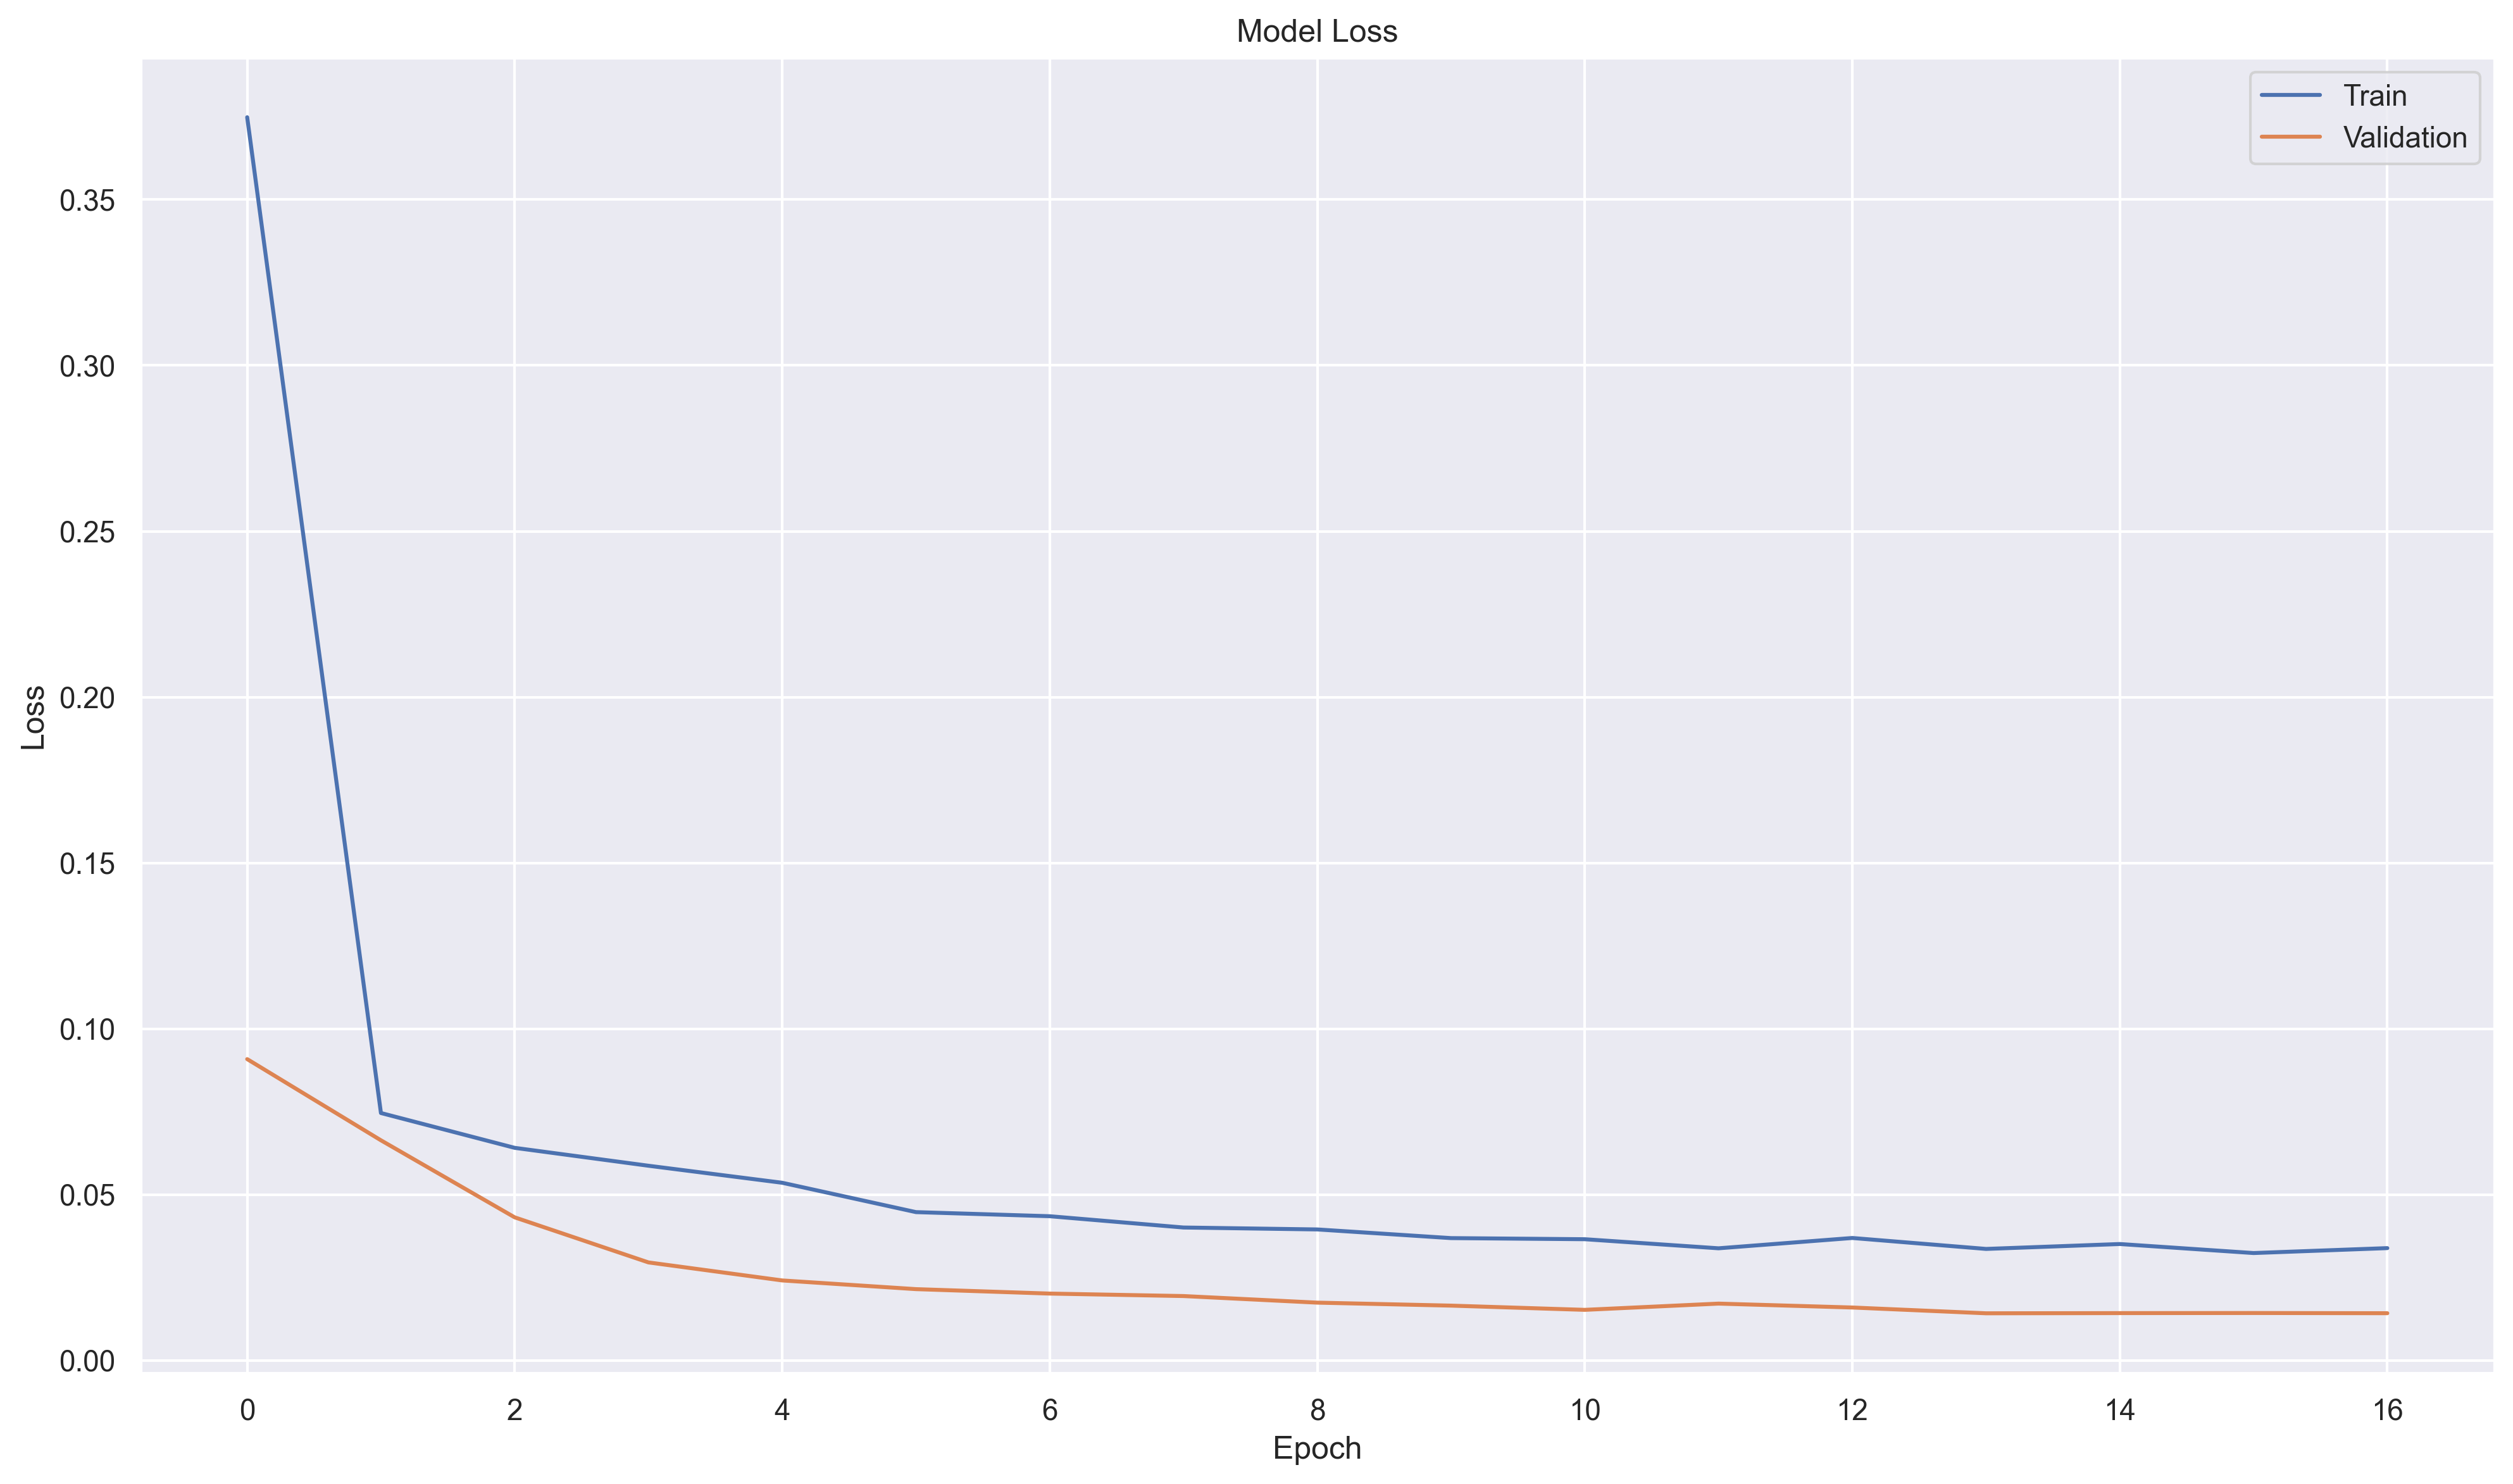

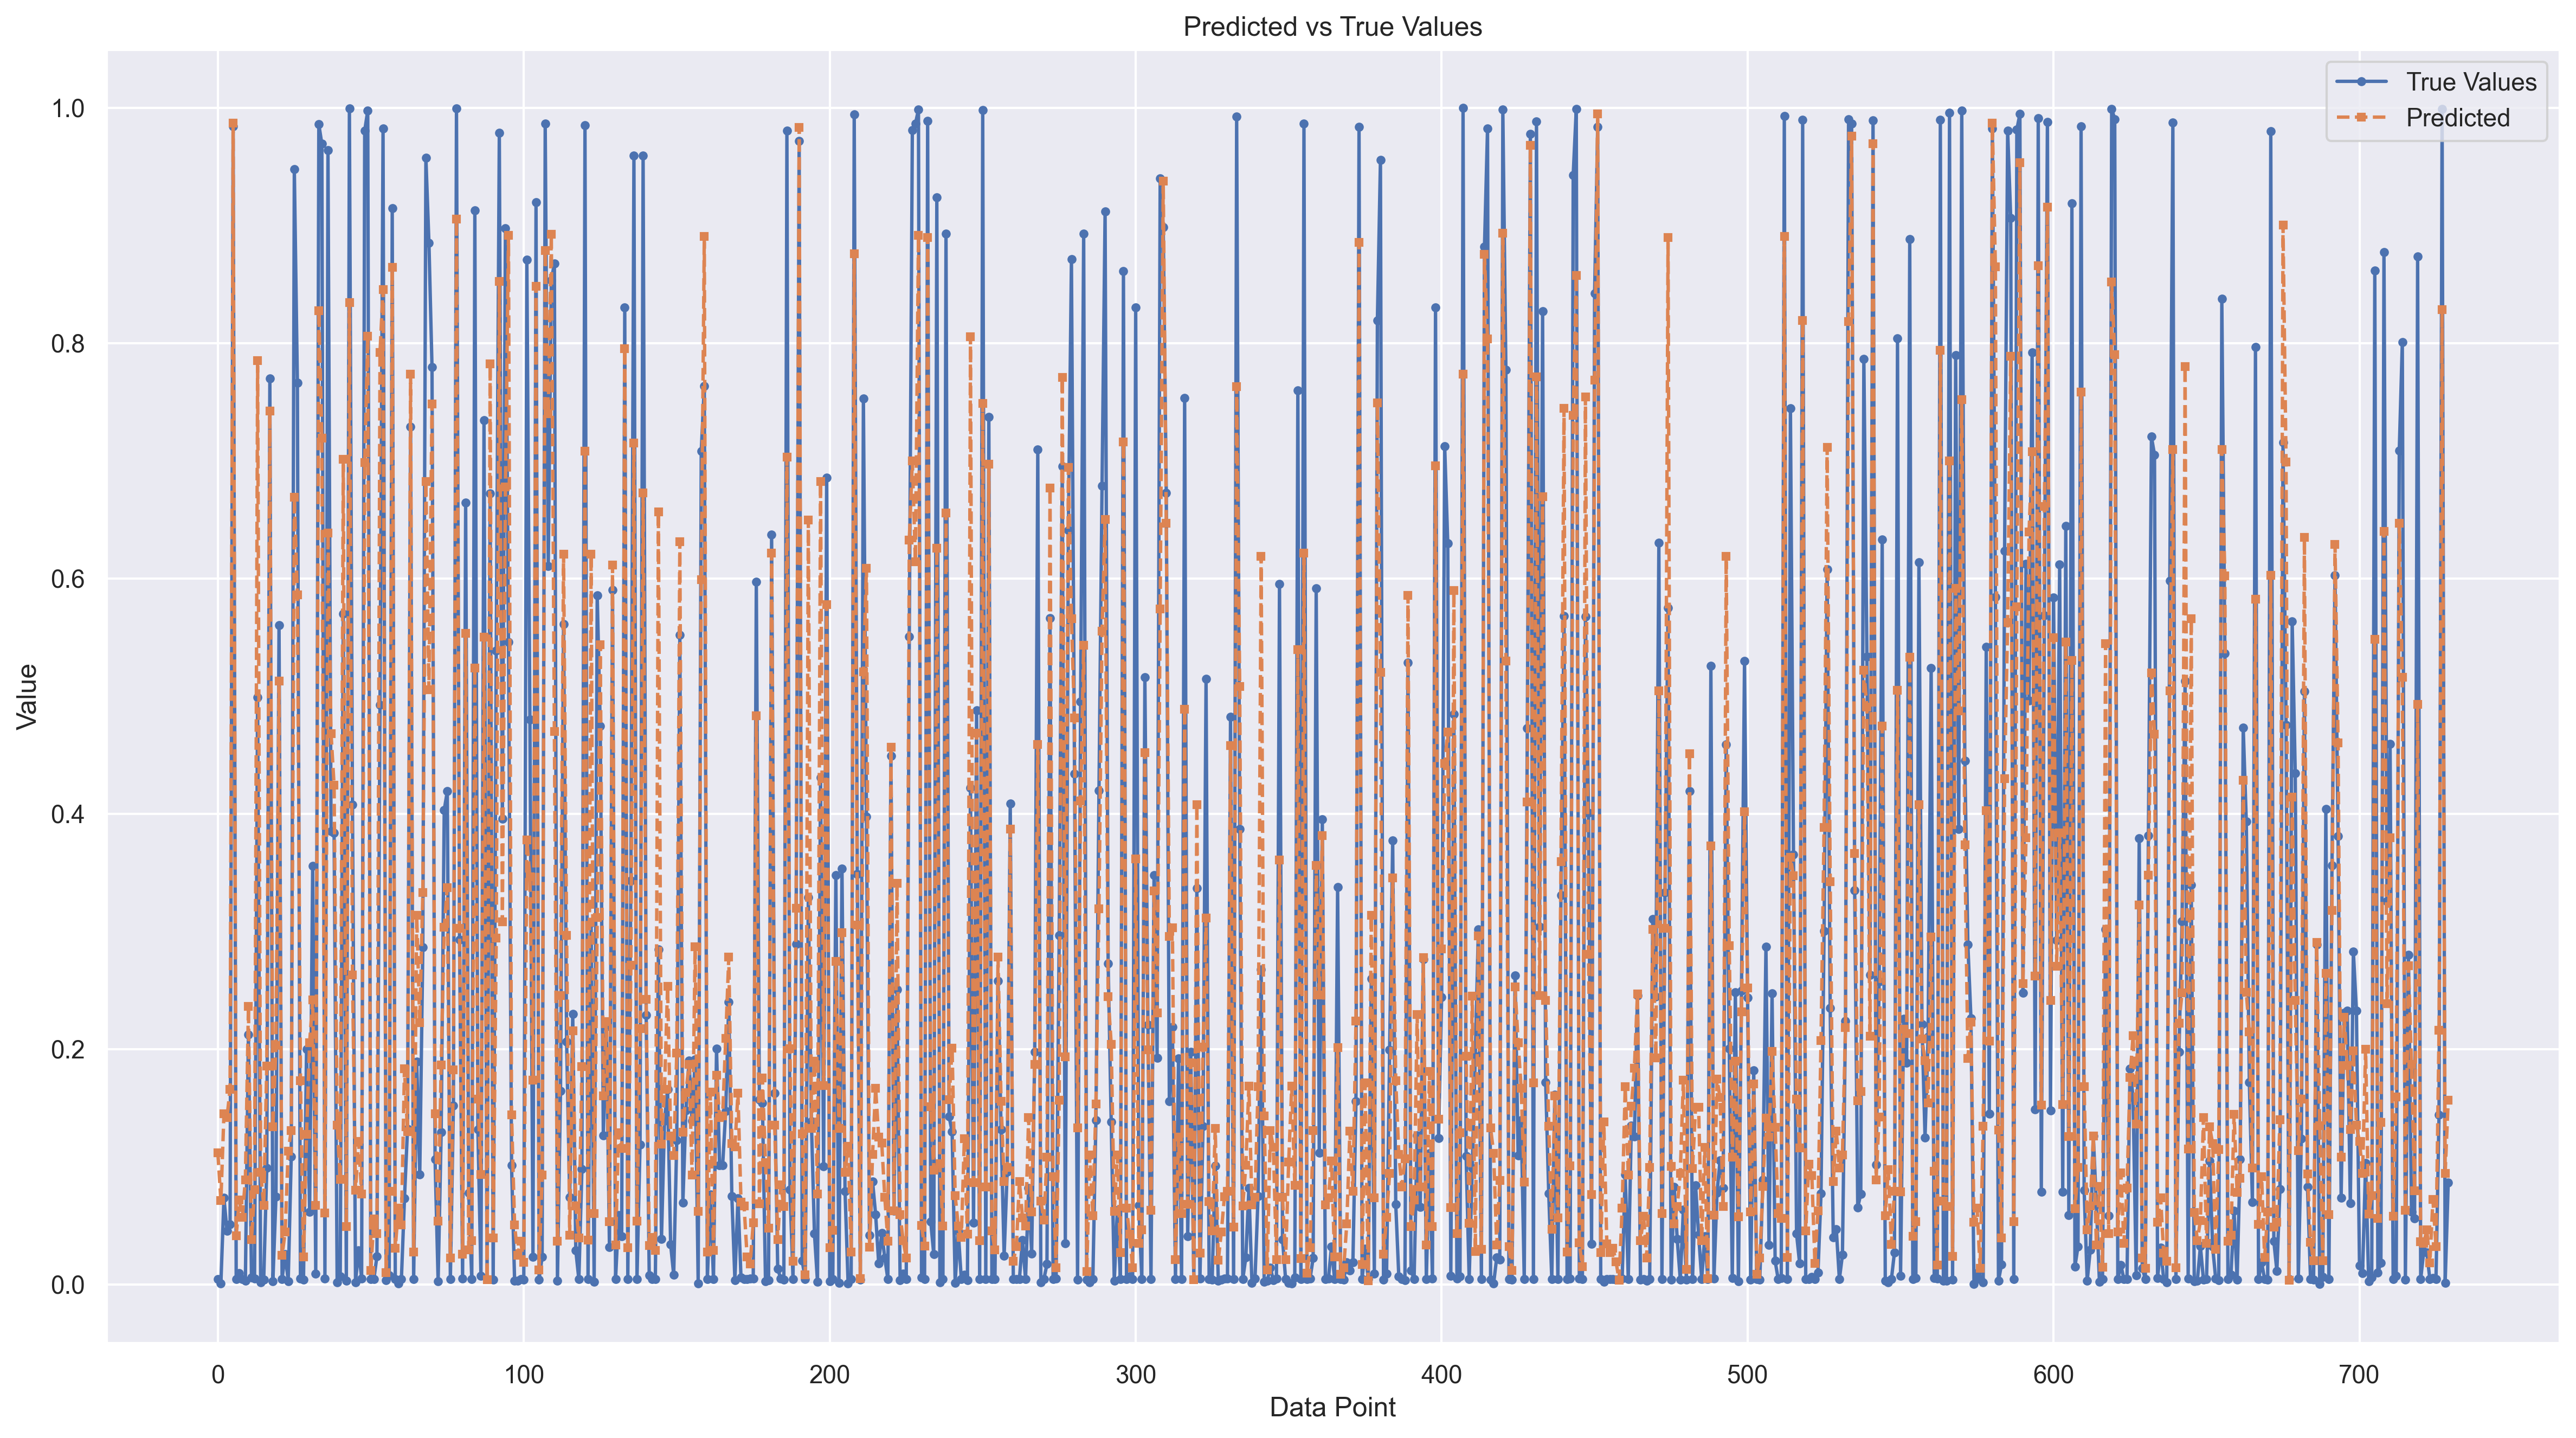

In [32]:
## 划分输入与输出
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
y = y.reshape(-1, 1)

# 归一化
# 最大最小归一化
minmax_scaler = MinMaxScaler()
X = minmax_scaler.fit_transform(X)
y = minmax_scaler.fit_transform(y)

# # zsocre标准化
# standard_scaler = StandardScaler()
# X = standard_scaler.fit_transform(X)
# y = standard_scaler.fit_transform(y)

## 划分训练集60%、测试集20%、测试集20%
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75)


#--------------------------------4、数据训练--------------------------------#

# 定义RBF层
class RBF_Layer(keras.layers.Layer):
    def __init__(self, n_centers, input_dim, **kwargs):
        super(RBF_Layer, self).__init__(**kwargs)
        self.centers = self.add_weight(
            shape=(n_centers, input_dim),
            initializer='random_normal',
            trainable=True
        )
        self.sigmas = self.add_weight(
            shape=(n_centers,),
            initializer='ones',
            trainable=True
        )

    def call(self, x):
        distances = tf.reduce_sum(tf.square(x[:, tf.newaxis, :] - self.centers[tf.newaxis, :, :]), axis=2)
        return tf.exp(-distances / (2 * tf.square(self.sigmas[tf.newaxis, :])))


# 定义神经网络
input_dim = X.shape[1]
def rbf_model():
    # 输入层
    inputs = Input(shape=(input_dim,))

    # 噪声层
    noise = GaussianNoise(0.1)(inputs)

    # RBF层
    rbf_out = RBF_Layer(n_centers=10, input_dim=input_dim)(noise)
    rbf_out = Flatten()(rbf_out)
    
    # 批量归一化层
    bn_out = BatchNormalization()(rbf_out)
    
    # Dropout层
    dropout = Dropout(0.3)(bn_out)

    # 输出层
    output = Dense(1, activation='softplus')(dropout)

    model = Model(inputs=[inputs], outputs=output)
    return model

# 创建RBF模型实例
rbf = rbf_model()

# 输出模型结构
print(rbf.summary())

# 编译模型，选择合适的优化器、学习率和损失函数
learning_rate = 0.005
rbf.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate), loss='mse')

## 参数
early_stopping_patience = 3
epoch = 20
batch_size = 16

# 训练模型
# 早停法--验证集损失连续3个epoch没有改善就停止训练
early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
# 动态调整学习率--在训练过程中，当验证集的损失不再下降（达到平台期）时自动降低学习率
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
history = rbf.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

# 绘制训练和验证损失曲线
plt.figure(figsize=(16, 9), dpi=300)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig(fname='rbf_损失曲线.png')

# 在测试集上评估模型
y_pred_test = rbf.predict(X_test)
mse_test_RBF = mean_squared_error(y_test, y_pred_test)
print('测试集MSE:', mse_test_RBF)
rmse_test_RBF = np.sqrt(mse_test_RBF)
print('测试集RMSE:', rmse_test_RBF)
mae_test_RBF = mean_absolute_error(y_test, y_pred_test)
print('测试集MAE:', mae_test_RBF)
mape_test_RBF = mean_absolute_percentage_error(y_test, y_pred_test)
print('测试集MAPE:', mape_test_RBF)
r2_test_RBF = r2_score(y_test, y_pred_test)
print('测试集R2:', r2_test_RBF)

## 拟合情况
plt.figure(figsize=(16, 9), dpi=300)
plt.plot(y_test, label='True Values', linestyle='-', marker='o', markersize=3)
plt.plot(y_pred_test, label='Predicted', linestyle='--', marker='s', markersize=3)
plt.title('Predicted vs True Values')
plt.ylabel('Value')
plt.xlabel('Data Point')
plt.legend()
plt.tight_layout()
plt.savefig(fname='RBF预测值与真实值拟合情况.png')